In [1]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import Plot as plot
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import datetime
import pickle
import os
import scipy.spatial
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as plt
import logging
from scipy import signal
import learningAlgs as classImportLA
import dataManipulation as dataMan
from itertools import permutations
import importlib
from datetime import timedelta
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
import timeIntervalPlotter as intervalPlotter
import pysal
import warnings
import lumping_traditional as oldLumping
import boundaryFull_SS_WeightedLumping as WLumping
from importlib import reload
from scipy.stats import rayleigh
import dataManipulation as dataMan
import matplotlib.pyplot as plt
import processData as processData
import tensorflow as tf
# import tensorflow_probability as tfp
import random
from random import shuffle

warnings.filterwarnings('always')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/home/sepehr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/sepehr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/sepehr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/sepehr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

In [ ]:
import pkg_resources
pkg_resources.get_distribution("tensorflow").version

# Fetching Feature Engineered Data

In [90]:
data = pd.read_pickle("30min_featureEngineer.pickle")
# data.to_pickle("30min_featureEngineer.pickle")

# Preparing Data for Training and Testing

In [84]:
def classifying(CU, boundaries):
    occupiedBandwidth = (CU / 255) * 100
    for i in range(len(boundaries)):
        if occupiedBandwidth <= boundaries[i]:
            return i

In [85]:
def naive(data, timeIndexes, boundaries):
    wholeDataFrame = data.loc[(data["timeIndex"] == timeIndexes)].copy()
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))
    prevCU_class = 0
    true_prediction = 0
    whole_samples = 0
    y_prediction = []
    y_true = []
    for index, row in wholeDataFrame.iterrows():
        whole_samples += 1
        if row["cuClass"] == prevCU_class:
            true_prediction += 1
        y_prediction.append(prevCU_class)
        y_true.append(row["cuClass"])
        prevCU_class = row["cuClass"]

    accuracy = true_prediction/whole_samples
    precision = precision_score(y_true, y_prediction, average='weighted')
    recall = recall_score(y_true, y_prediction, average='weighted')
    f1Score = f1_score(y_true, y_prediction, average='weighted')            

    return accuracy, precision, recall, f1Score

In [86]:
def dataPreparation(data, timeIndexes, minuteSplit, boundaries, steps):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    x = timeIndexes
    wholeDataFrame = data.loc[(data["timeIndex"] == x)].copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    prevCUVal = 1
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = 48 + 2*len(boundaries) + 2 + 48
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    wholeDataFrame.reset_index()
    for index, row in wholeDataFrame.iterrows():
        if (index + steps) not in wholeDataFrame.index:
            continue
        booleanCont = 0
        for stationary in range(1, 48):
            if (index - stationary*steps) not in wholeDataFrame.index:
                booleanCont = 1
                continue
        if booleanCont == 1:
            continue
            
        XArraysForLearning[pandasIndexCounter, 0] = row["normalLogDiff"]
        for stationary in range(1, 48):
                XArraysForLearning[pandasIndexCounter, stationary] = wholeDataFrame.loc[index - stationary*steps]["normalLogDiff"]
                

        XArraysForLearning[pandasIndexCounter, 48 + wholeDataFrame.loc[index - steps]["cuClass"]] = 1
        XArraysForLearning[pandasIndexCounter, 48 + len(boundaries) + row["cuClass"]] = 1
        XArraysForLearning[pandasIndexCounter, 48 + 2 * len(boundaries)] = (wholeDataFrame.loc[index - steps]["CU"]/255)
        XArraysForLearning[pandasIndexCounter, 48 + 2 * len(boundaries) + 1] = (row["CU"] / 255)
        for corrs in range(48):
            XArraysForLearning[pandasIndexCounter, (48 + 2 * len(boundaries)) + 2 + corrs] = row["corr" + str(corrs + 1)]

#         diffLogValue = (np.log(row["CU"]) - np.log(wholeDataFrame.loc[index - steps]["CU"]))/ (np.log(255) - np.log(1))
        YArraysForLearning[pandasIndexCounter, wholeDataFrame.loc[index + steps]["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        prevCUVal = row["CU"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries


# TensorFlow Function Running

In [87]:
def tensorFlowLossFunction(
    lossFuncBool, XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries):
    
    CUDA_VISIBLE_DEVICES=""
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    
    batch_size = 64
    learning_rate = 0.01
    beta = 0.1
    numOfEpochs = 400
    graph = tf.Graph()
    with graph.as_default():
#         x = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1]))
#         y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
#         W = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1], YArraysForLearning.shape[1]], seed = 0), name="weights", dtype=tf.float32)
#         b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)

        tf_test_dataset64 = tf.constant(XArraysForTesting)
        tf_test_dataset = tf.cast(tf_test_dataset64, tf.float32)

        
        x0 = tf.placeholder(tf.float32, shape = (batch_size, 48))
        x1 = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1] - 48))
        y0 = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1] - 47))
        y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
        W0 = tf.Variable(tf.truncated_normal([48, 1], seed = 0), name="weights0", dtype=tf.float32)
        W1 = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1] - 47, YArraysForLearning.shape[1]], seed = 0), name="weights1", dtype=tf.float32)
        b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)
        print(x0)
        print(x1)
        print(W0)
        print(W1)
        
        result = tf.matmul(x0, W0)
#         print(y0)
        concated = tf.concat([result, x1], axis = 1)
#         print(concated)
        logits = tf.matmul(concated, W1)
        train_prediction = tf.nn.softmax(logits)
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)

        beta = 0.05
        
#         train_prediction = tf.nn.softmax(logits)
        # train_prediction = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_, logits = logits)
        testing = tf.concat([tf.matmul(tf_test_dataset[:,:48], W0), tf_test_dataset[:,48:]], axis = 1)
        test_prediction = tf.nn.softmax(tf.matmul(testing, W1))
        
#         logits = tf.matmul(x, W)

        # x = XArraysForLearning[0:(0 + batch_size), :]
        # y_ = tf.Variable(YArraysForLearning[0:(0 + batch_size), :])

        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        
#         if lossFuncBool == 0:
#             loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)
        
#         elif lossFuncBool == 1:
#             loss = assymetricLossFunction(train_prediction, y_, boundaries)
#         dist = tfp.distributions.Multinomial(total_count=1, logits=logits)
#         loss = loss - (dist.log_prob(mult))
        # regularizer = tf.nn.l2_loss(W)
        # loss = tf.reduce_mean(loss + beta * regularizer)
        # loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = train_prediction, labels = y_)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        prevAcc = 0
        prevLoss = np.inf

    with tf.Session(graph=graph) as session:
        initializer = tf.contrib.layers.xavier_initializer()
        tf.set_random_seed(0)
        W0 = tf.Variable(initializer([48, 1]))
        W1 = tf.Variable(initializer([XArraysForLearning.shape[1] - 47, YArraysForLearning.shape[1]]))
#         b = tf.Variable(initializer([YArraysForLearning.shape[1]]))       
        tf.global_variables_initializer().run()
#         print(W.eval())
        
        print("Initialized")

        numberOfBatchIteration = int(XArraysForLearning.shape[0] / batch_size)
        restOfData = XArraysForLearning.shape[0] % batch_size
        if restOfData != 0:
            numberOfBatchIteration += 1

        accuracy_result = 0
        accuracy_earlyStop = 0
        earlyStoppingCounter = 0
        
        for epoch in range(numOfEpochs):
            accuracyValue = 0
            lossValue = 0
            totalBatch = 0
            i = 0
            randomize = np.arange(XArraysForLearning.shape[0])
            random.Random(epoch).shuffle(randomize)
            XArraysForLearning = XArraysForLearning[randomize]
            YArraysForLearning = YArraysForLearning[randomize]

            for iteration in range(numberOfBatchIteration):
                if (iteration == numberOfBatchIteration - 1) and restOfData != 0:
                    break
                    batch_data = XArraysForLearning[i:, :]
                    batch_labels = YArraysForLearning[i:, :]

                else:
                    batch_data_x0 = XArraysForLearning[i:(i + batch_size), :48]
#                     print(batch_data_x0.shape)
                    batch_data_x1 = XArraysForLearning[i:(i + batch_size), 48:]
#                     print(batch_data_x1.shape)
                    batch_labels = YArraysForLearning[i:(i + batch_size), :]

                    i += batch_size


                feed_dict = {x0 : batch_data_x0, x1: batch_data_x1, y_ : batch_labels}
#                 print(y0.shape)
#                 print("aaaaaaaa")
#                 print(feed_dict)
                _, predictions, l = session.run([optimizer, train_prediction, loss], feed_dict=feed_dict)

#                 print(l)
                lossValue *= (iteration)
                lossValue += (np.sum(l))
                lossValue /= (iteration + 1)
                totalBatch += batch_size
#                     print(accuracy(batch_data, batch_labels))
                accuracyValue += accuracy(predictions, batch_labels) * batch_size
                
            testAcc = accuracy(test_prediction.eval(), YArraysForTesting)
            if testAcc < prevAcc and earlyStoppingCounter == 100:
                print(prevAcc)
                break

            elif testAcc < prevAcc:
                earlyStoppingCounter += 1

            elif testAcc >= prevAcc:
                prevAcc = testAcc
                earlyStoppingCounter = 0

            totalAccuracy = accuracyValue/totalBatch
#             print(session.run(W))
#             test_result = test_prediction.eval()
            if epoch % 20 == 0:
                print("epoch ", epoch, totalAccuracy, testAcc, lossValue)

#             print(accuracy(test_result, YArraysForTesting), prevAcc, earlyStoppingCounter)
                
            



        # print(session.run(W))
        predictionResult = test_prediction.eval()
        accResult = accuracy(predictionResult , YArraysForTesting)
        penaltyValue = assymetricPredictionScore(predictionResult, YArraysForTesting, boundaries)
#         print(W.eval())
        accuracy_result = prevAcc
        if accResult > prevAcc:
            accuracy_result = accResult
            
        correctLableIndex = np.argmax(YArraysForTesting, 1)
        predictionIndex = np.argmax(predictionResult, 1)
        
        precision = precision_score(correctLableIndex, predictionIndex, average='weighted')
        recall = recall_score(correctLableIndex, predictionIndex, average='weighted')
        f1Score = f1_score(correctLableIndex, predictionIndex, average='weighted')            
        
        return accuracy_result, penaltyValue, precision, recall, f1Score
            
    
def assymetricPredictionScore(predictedLables, trueLables, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338

    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    minState = np.argmin(inverseDistrib)

    underUtilizedSum = 0
    overUtilizedSum = 0
    numberOfUnderUtilizedStates = minState - 0
    numberOfOverUtilizedStates = maxState - minState

    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100

    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)

    diffPercentage = np.zeros(shape = (predictedLables.shape))

    penalties = np.zeros(shape = (predictedLables.shape))

    for index in range(predictedLables.shape[0]):
        diffPercentage[index] = boundaries[correctLableIndex[index]] - boundaries[:]


    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            if diffPercentage[i][j] > 0:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * overUtilVal)]
            else:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * underUtilVal)]

    sumOfPenalty = 0
    for i in range(predictionIndex.shape[0]):
        penalties[i] = penalties[i] / np.sum(penalties[i])
        sumOfPenalty += penalties[i][predictionIndex[i]]

    return sumOfPenalty
    
    
def accuracy(predictedLables, trueLables):
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)
    errors = [0 for i in range(trueLables.shape[1])]
    corrects = [0 for i in range(trueLables.shape[1])]
    for i in range(len(correctLableIndex)):
        if correctLableIndex[i] != predictionIndex[i]:
            errors[correctLableIndex[i]] += 1
            corrects[predictionIndex[i]] += 1

    acc = np.float64(np.sum(correctLableIndex == predictionIndex)/predictedLables.shape[0])
    return acc
    
    
def assymetricLossFunction(prediction, correctLable, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338
    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    inverseDistrib = tf.constant(inverseDistrib)
    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]
    minState = np.argmin(inverseDistrib)
    numberOfOverUtilizedStates = maxState - minState
    numberOfUnderUtilizedStates = minState
    minState = tf.constant(minState, tf.float32)
    numberOfOverUtilizedStates = tf.constant(numberOfOverUtilizedStates, tf.float32)
    numberOfUnderUtilizedStates = tf.constant(numberOfUnderUtilizedStates, tf.float32)

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100


    boundaries = tf.constant(boundaries, tf.float32)
    correctLableIndex = tf.argmax(correctLable, 1)

    diffPercentage = []
    for index in range(correctLableIndex.shape[0]):
        diffPercentage.append(boundaries[correctLableIndex[index]] - boundaries[:])

    diffPercentage = tf.stack(diffPercentage)

    penalties = []

    counter = 0
    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            counter += 1

            penalties.append(tf.cond(
                    tf.greater(diffPercentage[i][j], 0),
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul(diffPercentage[i][j],
                                                                                       overUtilVal)), tf.int32)],
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul
                                                                    (diffPercentage[i][j], underUtilVal))
                                                                   , tf.int32)]
                    ))

    penalties = tf.stack(penalties)
    penalties = tf.dtypes.cast(penalties, tf.float32)
    penalties = tf.reshape(penalties, diffPercentage.shape)
#     penalties = penalties / tf.norm(penalties)

    # weights = tf.reduce_sum(penalties * (1-prediction), axis=1)
    weights = (1 - penalties) * prediction
    weights = weights / tf.norm(weights)
    # print(correctLable)
    # print(prediction)
    # print(penalties)
    loss = tf.losses.softmax_cross_entropy(onehot_labels = correctLable, logits = weights)
    # weighted_losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = penalties, logits = prediction)
    # loss = tf.reduce_sum(weighted_losses)
    # loss = tf.reduce_sum(penalties * prediction)
    return tf.reduce_mean(loss)

# Fetching Lumped Matrices with their Bandwidths

# 6 Classes

In [93]:
name = "/home/sepehr/thesis/APDataML/normalBoundaries_30min.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [94]:
normalLumping[0]

[(1.0,
  40.0799560546875,
  array([[0.83597884, 0.        , 0.        , 0.        , 0.        ,
          0.        ],
         [0.3968254 , 0.20052083, 0.03125   , 0.        , 0.        ,
          0.        ],
         [0.3       , 0.14285714, 0.2       , 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.25      , 0.        ,
          0.        ],
         [0.33333333, 0.        , 0.        , 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        ]]),
  [-1, 19, 30, 46, 60, 67, 79])]

In [95]:
percentageArray = []
for i in range(48):
    name = "/home/sepehr/thesis/APDataML/pickles/normal_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [747]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]
wieghts = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

resultDataFrameWithPenalty = pd.DataFrame(testDataFrame)
resultDataFrameWithPenalty = resultDataFrameWithPenalty.astype('object')

resultDataFrameNoPenalty = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty = resultDataFrameNoPenalty.astype('object')

In [164]:
normalLumping[0][0]

(1.0,
 40.0799560546875,
 array([[0.83597884, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.3968254 , 0.20052083, 0.03125   , 0.        , 0.        ,
         0.        ],
        [0.3       , 0.14285714, 0.2       , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.25      , 0.        ,
         0.        ],
        [0.33333333, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]]),
 [-1, 19, 30, 46, 60, 67, 79])

In [748]:
warnings.filterwarnings('ignore')
for timeIndex in range(48):
    if len(normalLumping[timeIndex]) == 0:
        continue
#     print(normalLumping[timeIndex][0][3])
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)

    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
# #     print(accuracy_result, penaltyValue)
    resultDataFrameNoPenalty.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 24.31372549  35.29411765  51.37254902  65.09803922  77.25490196
 100.        ]
start training set generation
19075
4769
starting tensor
Initialized
epoch  0 0.9140100671140939 20.19766051817261
epoch  20 0.9551698825503355 7.352549448509346
epoch  40 0.9543833892617449 7.188058107091276
epoch  60 0.95564177852349 7.009139636018932
epoch  80 0.9551698825503355 6.943598757454213
epoch  100 0.9553271812080537 6.940837676693129
epoch  120 0.9561661073825504 6.948141232132912
epoch  140 0.9562709731543624 6.96056114887231
epoch  160 0.9564282718120806 6.832959062701104
epoch  180 0.9561136744966443 6.891519272087407
epoch  200 0.957005033557047 6.846595784861769
epoch  220 0.957005033557047 6.831641212405773
epoch  240 0.9563758389261745 6.850649087621066
epoch  260 0.9572671979865772 6.813288582251378
epoch  280 0.957057466442953 6.761242800510971
epoch  300 0.9567428691275168 6.859820257897351
epoch  320 0.9572671979865772 6.807899311684923
epoch  340 0.957109899328859 6.7623487580942

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



1
[ 24.31372549  38.03921569  48.23529412  59.21568627  78.03921569
 100.        ]
start training set generation
18820
4706
starting tensor
Initialized
epoch  0 0.9169323979591837 18.482305105040666
epoch  20 0.9568983843537415 7.057902349906714
epoch  40 0.9573767006802721 6.902487668861335
epoch  60 0.9562074829931972 6.916027829760594
epoch  80 0.9578018707482994 6.827672798617357
epoch  100 0.9559948979591837 7.065501373844083
epoch  120 0.9576955782312925 6.749965103305116
epoch  140 0.9575361394557823 6.809197254732352
epoch  160 0.9574298469387755 6.871247351727111
epoch  180 0.9568983843537415 6.823109997373049
epoch  200 0.9567389455782312 6.816479875725142
epoch  220 0.9581207482993197 6.7194891973417645
epoch  240 0.9578018707482994 6.772999395318583
epoch  260 0.9578550170068028 6.885061341483577
epoch  280 0.9562074829931972 6.8111088140075715
epoch  300 0.9576955782312925 6.730838733060018
epoch  320 0.9568452380952381 6.7612347352464175
epoch  340 0.9574829931972789 6.78

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



4
[ 24.31372549  38.03921569  48.23529412  63.1372549   82.35294118
 100.        ]
start training set generation
18919
4730
starting tensor
Initialized
epoch  0 0.9217690677966102 16.97097721099853
epoch  20 0.9611758474576271 6.5297996401786795
epoch  40 0.9619703389830508 6.277093388064432
epoch  60 0.9630826271186441 6.266320059461105
epoch  80 0.9622351694915254 6.162893057071557
epoch  100 0.9627118644067797 6.171753679089625
epoch  120 0.9623940677966102 6.116681726302133
epoch  140 0.9636652542372881 6.098742977845469
epoch  160 0.963718220338983 6.053489184985729
epoch  180 0.9635593220338983 6.0121769741430136
epoch  200 0.9621822033898305 6.101676577834758
epoch  220 0.9628177966101695 6.114744568477243
epoch  240 0.9629237288135594 6.07717338214486
epoch  260 0.9641949152542373 5.980656525846253
epoch  280 0.9638771186440678 6.026160887136298


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



5
[ 24.31372549  47.05882353  57.25490196  68.23529412  83.1372549
 100.        ]
start training set generation
18826
4707
starting tensor
Initialized
epoch  0 0.9241602891156463 14.80699007689548
epoch  20 0.9643388605442177 5.7995301806399615
epoch  40 0.9648171768707483 5.696069263580708
epoch  60 0.9654549319727891 5.800598220152111
epoch  80 0.9658801020408163 5.6176236507032975
epoch  100 0.9643388605442177 5.694642885404378
epoch  120 0.9652954931972789 5.64848228640297
epoch  140 0.9650829081632653 5.646464248498286
epoch  160 0.9657206632653061 5.5962984152391675
epoch  180 0.9654017857142857 5.528657322027248
epoch  200 0.9655080782312925 5.636645836286804
epoch  220 0.9667835884353742 5.527235860321799
epoch  240 0.9654017857142857 5.535514817756862
epoch  260 0.9659863945578231 5.545008619322259
epoch  280 0.9661458333333334 5.4893636465275355
epoch  300 0.9654017857142857 5.57526028379291
6
[ 23.1372549   33.33333333  46.2745098   58.03921569  69.01960784
 100.        ]
st

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



7
[ 23.1372549   34.11764706  45.09803922  56.07843137  77.25490196
 100.        ]
start training set generation
18736
4684
starting tensor
Initialized
epoch  0 0.9056613869863014 19.715330661159676
epoch  20 0.950556506849315 7.960173576661987
epoch  40 0.9503424657534246 7.898534880109026
epoch  60 0.9527504280821918 7.528986767342646
epoch  80 0.9527504280821918 7.5682318945453595
epoch  100 0.9521618150684932 7.534055243207984
8
[ 24.31372549  38.03921569  49.01960784  61.17647059  84.31372549
 100.        ]
start training set generation
19328
4833
starting tensor
Initialized
epoch  0 0.9147868377483444 16.996378289153245
epoch  20 0.9576262417218543 6.754796153662221
epoch  40 0.9569019039735099 6.855042598894891
epoch  60 0.9581436258278145 6.638554954568284
epoch  80 0.9588162251655629 6.591465752645834
epoch  100 0.9592301324503312 6.659596958697236
epoch  120 0.9584023178807947 6.553020392624749
epoch  140 0.9591783940397351 6.541269126514728
epoch  160 0.9591266556291391 6.56

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



10
[ 24.31372549  47.05882353  57.25490196  70.19607843  87.05882353
 100.        ]
start training set generation
18725
4682
starting tensor
Initialized
epoch  0 0.9045376712328768 16.57410477775416
epoch  20 0.9568707191780822 6.939872408770535
epoch  40 0.9584225171232876 6.8159415103393055
epoch  60 0.957833904109589 6.794835592990052
epoch  80 0.9571382705479452 6.727496372102056
epoch  100 0.9576198630136986 6.661212775396972
epoch  120 0.9591716609589042 6.625857538556399
epoch  140 0.9586900684931506 6.724483221156953
epoch  160 0.9590111301369864 6.720354439052817
epoch  180 0.958101455479452 6.681642824452218
epoch  200 0.9590111301369864 6.6316727065060235


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



12
[ 10.19607843  23.1372549   33.33333333  54.11764706  65.09803922
 100.        ]
start training set generation
18581
4646
starting tensor
Initialized
epoch  0 0.7820043103448275 41.570633447581315
epoch  20 0.8989224137931034 15.819751910505623
epoch  40 0.9035021551724138 15.291305829738748
epoch  60 0.9045797413793103 15.076198107620765
epoch  80 0.905603448275862 14.970609372237632
epoch  100 0.9058728448275862 14.956142101616695
epoch  120 0.9043103448275862 14.880833844480843
epoch  140 0.9060344827586206 14.841175620309238
epoch  160 0.9073814655172414 14.839016130052764
epoch  180 0.905334051724138 14.774550783223122


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



13
[ 24.31372549  36.07843137  50.19607843  60.39215686  76.07843137
 100.        ]
start training set generation
18308
4578
starting tensor
Initialized
epoch  0 0.8895323426573427 22.291045482342067
epoch  20 0.9449847027972028 8.95158358053728
epoch  40 0.9474431818181818 8.712477999550485
epoch  60 0.9488090034965035 8.468783762071519
epoch  80 0.9503933566433567 8.348979062967365
epoch  100 0.9480987762237763 8.358755473073552
epoch  120 0.9478802447552448 8.440896498573412
epoch  140 0.9492460664335665 8.267161056295135
epoch  160 0.9485358391608392 8.376710379040329
epoch  180 0.9493006993006993 8.261699078799966
epoch  200 0.9477709790209791 8.389934009605357
epoch  220 0.9484812062937062 8.28120255803729
epoch  240 0.9489729020979021 8.235091526608361
epoch  260 0.9483173076923077 8.310379956985685
14
[ 17.25490196  39.21568627  50.19607843  61.17647059  75.29411765
 100.        ]
start training set generation
18322
4581
starting tensor
Initialized
epoch  0 0.7506009615384616 4

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



15
[ 11.37254902  36.07843137  48.23529412  59.21568627  80.39215686
 100.        ]
start training set generation
18394
4599
starting tensor
Initialized
epoch  0 0.8580683797909407 30.94975867254809
epoch  20 0.9213850174216028 12.740518850731934
epoch  40 0.9234538327526133 12.293792349951607
epoch  60 0.9239982578397212 12.179478489978806
epoch  80 0.9248148954703833 12.14431718625258
epoch  100 0.9238349303135889 12.088339910274598
epoch  120 0.9241615853658537 12.045742272499961
epoch  140 0.9242704703832753 11.963822861581727
epoch  160 0.9251415505226481 11.8894560968419
epoch  180 0.9258493031358885 11.977940208820517
epoch  200 0.9239438153310104 11.885955111074942
epoch  220 0.9256315331010453 11.85147086419295
epoch  240 0.9247060104529616 11.907953663570124
epoch  260 0.9248148954703833 11.88280307789713
epoch  280 0.9259037456445993 11.830329908311162
epoch  300 0.9233993902439024 11.884833890801943
epoch  320 0.9245426829268293 11.791201042381317
epoch  340 0.9249782229965

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



17
[ 13.33333333  37.25490196  48.23529412  60.39215686  84.31372549
 100.        ]
start training set generation
18687
4672
starting tensor
Initialized
epoch  0 0.8404209621993127 31.620460552857907
epoch  20 0.9121026632302406 14.690385330173978
epoch  40 0.9148947594501718 14.187591220095392
epoch  60 0.9124248281786942 14.26057596304982
epoch  80 0.9140356529209622 14.197110802037612
epoch  100 0.912317439862543 14.158523448963752
epoch  120 0.9150558419243986 14.048702377633953
epoch  140 0.9146799828178694 13.999401521027293
epoch  160 0.914196735395189 14.233445890171012


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18
[ 12.15686275  36.07843137  47.05882353  67.05882353  87.05882353
 100.        ]
start training set generation
18660
4666
starting tensor
Initialized
epoch  0 0.8454145189003437 30.67017564740785
epoch  20 0.9127469931271478 14.150025805247202
epoch  40 0.9134987113402062 13.798818765227328
epoch  60 0.9146262886597938 13.673480125636987
epoch  80 0.9145725945017182 13.61072135381273
epoch  100 0.9142504295532646 13.590327688918489
epoch  120 0.9160223367697594 13.50794801023817
epoch  140 0.914733676975945 13.464562405425657
epoch  160 0.9159686426116839 13.547665030685895
epoch  180 0.9155390893470791 13.503128936610274
epoch  200 0.9148410652920962 13.586766715721573
epoch  220 0.9124248281786942 13.547979003375339
epoch  240 0.9155390893470791 13.549853140545878


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19
[ 19.21568627  43.1372549   53.33333333  67.05882353  79.21568627
 100.        ]
start training set generation
18775
4694
starting tensor
Initialized
epoch  0 0.7591190273037542 41.44311340514305
epoch  20 0.8575085324232082 21.701962480772863
epoch  40 0.8623613481228669 21.199836493352166
epoch  60 0.8583084470989761 20.983108188511967
epoch  80 0.8605482081911263 20.862832560880992
epoch  100 0.8586284129692833 21.168944863329163
epoch  120 0.8609215017064846 20.899395776690074
epoch  140 0.859375 21.067041956930847
epoch  160 0.8599616040955631 20.8258142764251
epoch  180 0.8592683447098977 20.761258265264196
epoch  200 0.8599616040955631 20.79895201477989
epoch  220 0.8594816552901023 20.824651490299367
epoch  240 0.8605482081911263 20.713988219511798
epoch  260 0.8625746587030717 20.754559904235233
epoch  280 0.8604415529010239 20.745296670308303
epoch  300 0.8626279863481229 20.678525333925332
epoch  320 0.8613481228668942 20.71752704776594
epoch  340 0.862681313993174 20.665

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



25
[ 13.33333333  38.03921569  48.23529412  62.35294118  77.25490196
 100.        ]
start training set generation
18953
4739
starting tensor
Initialized
epoch  0 0.8253272804054054 35.50421517926295
epoch  20 0.8911528716216216 18.305615737631513
epoch  40 0.8923141891891891 17.739961595148653
epoch  60 0.8937394425675675 17.561338168543752
epoch  80 0.893528293918919 17.55782363704734
epoch  100 0.8952702702702703 17.487685683611293
epoch  120 0.8937922297297297 17.33307177956041
epoch  140 0.8957453547297297 17.47425859038894
epoch  160 0.8940561655405406 17.27932535957645
epoch  180 0.8957981418918919 17.33330056957296
epoch  200 0.8940033783783784 17.311719407906402
epoch  220 0.8947423986486487 17.404335044525766
epoch  240 0.8963788006756757 17.30974469635938
epoch  260 0.8951646959459459 17.255435086585365
epoch  280 0.8954286317567568 17.314586573355907
epoch  300 0.8960092905405406 17.325297962974854
epoch  320 0.8944784628378378 17.231310267706164
epoch  340 0.893739442567567

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



27
[ 12.15686275  36.07843137  57.25490196  68.23529412  80.39215686
 100.        ]
start training set generation
19624
4907
starting tensor
Initialized
epoch  0 0.7879901960784313 39.58059861301598
epoch  20 0.8689746732026143 20.113521610210157
epoch  40 0.8719362745098039 19.62658462649078
epoch  60 0.8719362745098039 19.38821669030033
epoch  80 0.8738255718954249 19.36083081033494
epoch  100 0.8727022058823529 19.219174149768797
epoch  120 0.8723447712418301 19.21037970648872
epoch  140 0.8725490196078431 19.220749403137006
epoch  160 0.8743872549019608 19.247603617462442
epoch  180 0.870812908496732 19.169970277088126
epoch  200 0.8735191993464052 19.134639517154568
epoch  220 0.8709660947712419 19.26945290534325
28
[ 11.37254902  36.07843137  57.25490196  69.01960784  89.01960784
 100.        ]
start training set generation
19170
4793
starting tensor
Initialized
epoch  0 0.8234218227424749 33.46847573730061
epoch  20 0.892767558528428 16.32216762778752
epoch  40 0.897313963210702

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



29
[ 13.33333333  38.03921569  53.33333333  71.37254902  89.01960784
 100.        ]
start training set generation
19549
4888
starting tensor
Initialized
epoch  0 0.79375 38.05098458274465
epoch  20 0.8756659836065573 19.357191123337035
epoch  40 0.8800717213114754 18.501802825927737
epoch  60 0.8797643442622951 18.275858818116728
epoch  80 0.8799180327868853 18.225187092140082
epoch  100 0.8811475409836066 18.182411687882198
epoch  120 0.8820696721311475 18.12702793840502
epoch  140 0.8814036885245902 18.173921672633437
epoch  160 0.8822745901639344 17.977843733302876
epoch  180 0.8824282786885246 17.983966711700948
epoch  200 0.8819672131147541 17.95053598216323
epoch  220 0.8817110655737705 17.99357449891138
epoch  240 0.8827868852459017 17.898057984524073
epoch  260 0.8829405737704918 17.911539165309225
30
[ 13.33333333  35.29411765  59.21568627  71.37254902  82.35294118
 100.        ]
start training set generation
19491
4873
starting tensor
Initialized
epoch  0 0.752210115131579 42

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



31
[ 11.37254902  36.07843137  60.39215686  76.07843137  87.05882353
 100.        ]
start training set generation
19115
4779
starting tensor
Initialized
epoch  0 0.7988150167785235 37.09051211888358
epoch  20 0.8871119966442953 17.81268067647946
epoch  40 0.8913590604026845 17.2144863781513
epoch  60 0.8905725671140939 16.94067521383297
epoch  80 0.8912017617449665 16.96319337339209
epoch  100 0.891935822147651 16.820837750530895
epoch  120 0.8916212248322147 16.73925940462404
epoch  140 0.8905201342281879 16.65238758541594
epoch  160 0.8913066275167785 16.78444519939039
epoch  180 0.8914114932885906 16.66435419473072
epoch  200 0.8924601510067114 16.603659865040107
epoch  220 0.8928271812080537 16.582068608111197
epoch  240 0.8911493288590604 16.59930548411888
epoch  260 0.8927747483221476 16.624337687588387
epoch  280 0.8924077181208053 16.558082980597582
32
[ 24.31372549  46.2745098   58.03921569  77.25490196  88.23529412
 100.        ]
start training set generation
19220
4805
start

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



33
[ 10.19607843  33.33333333  58.03921569  74.11764706  89.01960784
 100.        ]
start training set generation
19269
4818
starting tensor
Initialized
epoch  0 0.7967192691029901 36.58006865796062
epoch  20 0.8909883720930233 16.51816914960793
epoch  40 0.8962313122923588 15.850201126744977
epoch  60 0.8964908637873754 15.700352356679419
epoch  80 0.8958679401993356 15.542720696458785
epoch  100 0.8945701827242525 15.72335204729606
epoch  120 0.8960755813953488 15.580169931202631
epoch  140 0.897217607973422 15.527047886008836
epoch  160 0.8944144518272426 15.683594811398313
epoch  180 0.896906146179402 15.553412755858462
epoch  200 0.8978405315614618 15.572326118367851
epoch  220 0.8966985049833887 15.53328430613014


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



34
[ 14.11764706  28.23529412  52.15686275  63.1372549   75.29411765
 100.        ]
start training set generation
19083
4771
starting tensor
Initialized
epoch  0 0.7034920302013423 48.562544969904344
epoch  20 0.8472630033557047 23.339913969871986
epoch  40 0.8525062919463087 22.14622434193656
epoch  60 0.8538171140939598 21.774028029217817
epoch  80 0.8529781879194631 21.72832529656839
epoch  100 0.854184144295302 21.5373517394866
epoch  120 0.8557571308724832 21.55346910425479
epoch  140 0.8568057885906041 21.499370434140204
epoch  160 0.8570155201342282 21.307651276556424
epoch  180 0.8572252516778524 21.408131429813054
epoch  200 0.8550230704697986 21.47446645506276
epoch  220 0.8552328020134228 21.58864591265684
epoch  240 0.8546036073825504 21.38017940841266
epoch  260 0.8565960570469798 21.272455685890762
epoch  280 0.8565960570469798 21.250861375923936
epoch  300 0.8570155201342282 21.210209033633248
epoch  320 0.8543938758389261 21.301116146497275
epoch  340 0.8568057885906041

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



35
[ 11.37254902  36.07843137  48.23529412  63.1372549   82.35294118
 100.        ]
start training set generation
18983
4746
starting tensor
Initialized
epoch  0 0.8171980574324325 34.50033318996428
epoch  20 0.8953230574324325 16.601977651183677
epoch  40 0.8972233952702703 15.911352399233232
epoch  60 0.8986486486486487 15.78345151044227
epoch  80 0.898754222972973 15.611067446502476
epoch  100 0.8985430743243243 15.711548776239962
epoch  120 0.8982263513513513 15.583089174451056
epoch  140 0.8992820945945946 15.56517080197463
epoch  160 0.9000211148648649 15.534418692459932
epoch  180 0.8999683277027027 15.509734013596097
epoch  200 0.8991765202702703 15.47984041394414
epoch  220 0.8989125844594594 15.53998318395099
epoch  240 0.9011296452702703 15.41003741928049
epoch  260 0.8998627533783784 15.440396031817874
epoch  280 0.9004961993243243 15.378792395462861
epoch  300 0.8988597972972973 15.431337554712552
epoch  320 0.8997043918918919 15.436064549394557
epoch  340 0.89891258445945

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



37
[ 17.25490196  41.17647059  52.15686275  62.35294118  79.21568627
 100.        ]
start training set generation
18559
4640
starting tensor
Initialized
epoch  0 0.8009299307958477 35.836791470801565
epoch  20 0.8989511245674741 16.296202484711642
epoch  40 0.9000324394463668 15.947821074291085
epoch  60 0.8993295847750865 15.772646506352405
epoch  80 0.9004649653979239 15.62315797475795
epoch  100 0.9019788062283737 15.595084185418786
epoch  120 0.8992214532871973 15.81854886414683
epoch  140 0.901492214532872 15.516847059388475
epoch  160 0.9010596885813149 15.427061821762665


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



38
[ 10.19607843  34.11764706  51.37254902  68.23529412  79.21568627
 100.        ]
start training set generation
19177
4795
starting tensor
Initialized
epoch  0 0.8380539297658863 31.631003705155486
epoch  20 0.9177989130434783 13.212571957438287
epoch  40 0.9173285953177257 13.068447699913614
epoch  60 0.9195234113712375 12.712790360020154
epoch  80 0.9188440635451505 12.674527338117258
epoch  100 0.9194711538461539 12.524569972302995
epoch  120 0.9203595317725752 12.567058023401724
epoch  140 0.920516304347826 12.503601246454249
epoch  160 0.9198892140468228 12.57226837917315
epoch  180 0.919575668896321 12.510630706480912
epoch  200 0.9198369565217391 12.51613052712635
epoch  220 0.9196801839464883 12.505425285734859
epoch  240 0.919732441471572 12.43825724451837


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



39
[ 13.33333333  37.25490196  52.15686275  64.31372549  88.23529412
 100.        ]
start training set generation
19512
4878
starting tensor
Initialized
epoch  0 0.8271998355263158 34.20746472634767
epoch  20 0.9042454769736842 15.471130004054622
epoch  40 0.9042454769736842 15.074651038960406
epoch  60 0.9086143092105263 14.713595473452619
epoch  80 0.9077405427631579 14.715175553372031
epoch  100 0.9073807565789473 14.788600504398346
epoch  120 0.9084087171052632 14.647421709801021
epoch  140 0.9073807565789473 14.662698157523808
epoch  160 0.9061986019736842 14.62577665165851
epoch  180 0.9068153782894737 14.657738332685671
epoch  200 0.9086657072368421 14.5819186380035
epoch  220 0.9076377467105263 14.52834025182222
epoch  240 0.9092310855263158 14.506150876220904
epoch  260 0.9086143092105263 14.653658772769727
40
[ 24.31372549  49.01960784  59.21568627  70.19607843  80.39215686
 100.        ]
start training set generation
19080
4771
starting tensor
Initialized
epoch  0 0.83766778

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



41
[ 10.19607843  32.15686275  56.07843137  67.05882353  78.03921569
 100.        ]
start training set generation
18898
4725
starting tensor
Initialized
epoch  0 0.843114406779661 30.24510796757069
epoch  20 0.9265889830508475 12.005453593043958
epoch  40 0.926906779661017 11.592253971908054
epoch  60 0.9295021186440678 11.63805683750217
epoch  80 0.929396186440678 11.413624692367293
epoch  100 0.9289194915254237 11.332896114607985
epoch  120 0.9295550847457628 11.460789884146994
epoch  140 0.9300317796610169 11.340739669638163
epoch  160 0.9298199152542372 11.322210181769682
epoch  180 0.9304025423728813 11.343394921997842
epoch  200 0.9292372881355933 11.358726165254241
epoch  220 0.9296080508474577 11.370368551803844
epoch  240 0.9298199152542372 11.394515650151142
epoch  260 0.9305614406779661 11.295367537514641
epoch  280 0.9294491525423729 11.321447984646944
epoch  300 0.9295021186440678 11.28923411611783
epoch  320 0.929978813559322 11.256217363325216
epoch  340 0.92817796610169

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



42
[ 10.19607843  34.11764706  47.05882353  62.35294118  80.39215686
 100.        ]
start training set generation
19660
4915
starting tensor
Initialized
epoch  0 0.8491449511400652 29.212978574274434
epoch  20 0.9288477198697068 11.58957002061974
epoch  40 0.9309344462540716 11.286550698140552
epoch  60 0.9311380293159609 11.099001458879405
epoch  80 0.9313925081433225 11.078512112558467
epoch  100 0.9325631107491856 11.019623486925799
epoch  120 0.9324104234527687 11.023823841386971
epoch  140 0.9332247557003257 11.017538422482023
epoch  160 0.9318505700325733 10.977731828192544
epoch  180 0.9313925081433225 10.968768142333634
epoch  200 0.9320541530944625 10.913517816835586
epoch  220 0.9337846091205212 10.961247657719964
epoch  240 0.9341917752442996 10.82984343646792
epoch  260 0.9336828175895765 10.885676388631815
epoch  280 0.9335301302931596 10.887480421252674
epoch  300 0.9327157980456026 10.915284995535686
43
[ 10.19607843  32.15686275  50.19607843  60.39215686  75.29411765
 1

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



44
[ 27.05882353  37.25490196  48.23529412  59.21568627  70.19607843
 100.        ]
start training set generation
18884
4722
starting tensor
Initialized
epoch  0 0.9296610169491526 17.58122531034178
epoch  20 0.9565677966101694 6.999670359643839
epoch  40 0.9591631355932203 6.7319413815514535
epoch  60 0.9596398305084746 6.591328442753369
epoch  80 0.9601694915254237 6.553374836404445
epoch  100 0.9595338983050847 6.608993781219095
epoch  120 0.9594279661016949 6.714639016531281
epoch  140 0.9603283898305085 6.553385329246523
epoch  160 0.9596398305084746 6.557774020150555
epoch  180 0.9605402542372882 6.416780880750236
epoch  200 0.9606991525423729 6.488339746503507
epoch  220 0.9596927966101695 6.513258657617082
epoch  240 0.9605932203389831 6.551913072093057
epoch  260 0.9611758474576271 6.46415324786962
epoch  280 0.9599046610169492 6.491418225482359
epoch  300 0.9597457627118644 6.503633023722699


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



45
[ 24.31372549  47.05882353  57.25490196  70.19607843  80.39215686
 100.        ]
start training set generation
19144
4786
starting tensor
Initialized
epoch  0 0.891983695652174 20.371990069896487
epoch  20 0.9470108695652174 8.640700176009362
epoch  40 0.9473766722408027 8.508950691558038
epoch  60 0.9470108695652174 8.499101579787341
epoch  80 0.947324414715719 8.322423685354531
epoch  100 0.9474289297658863 8.293340674212143
epoch  120 0.9469586120401338 8.29155781914956
epoch  140 0.9487876254180602 8.254817757718138


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



46
[ 24.31372549  35.29411765  47.05882353  58.03921569  82.35294118
 100.        ]
start training set generation
19132
4784
starting tensor
Initialized
epoch  0 0.8969693791946308 22.274201444331432
epoch  20 0.9468854865771812 8.728404600348256
epoch  40 0.9481963087248322 8.362295551188042
epoch  60 0.94782927852349 8.41627887111381
epoch  80 0.9484060402684564 8.169285743528558
epoch  100 0.9475146812080537 8.240509020002103
epoch  120 0.9485109060402684 8.220670460454569
epoch  140 0.9490876677852349 8.124637012513697
epoch  160 0.9488255033557047 8.186167628173052
epoch  180 0.949297399328859 8.091766528235194
epoch  200 0.9490352348993288 8.078983237079322
epoch  220 0.9497168624161074 8.05554022284962
epoch  240 0.9500314597315436 8.206684211756556
47
[ 24.31372549  40.39215686  52.15686275  65.09803922  83.1372549
 100.        ]
start training set generation
0
0
starting tensor
Initialized


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



ZeroDivisionError: division by zero

In [412]:
resultDataFrameNoPenalty

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.95282,4.16943,0.958517,0.95282,0.955172,"[24.31372549019606, 35.29411764705877, 51.3725...",1,40.08
1,0.956014,4.99328,0.958371,0.956014,0.9569,"[24.31372549019606, 38.039215686274446, 48.235...",1,29.2262
2,0.938984,5.45695,0.949628,0.938984,0.942705,"[23.13725490196077, 37.25490196078425, 48.2352...",1,20.4296
3,0.926629,15.892,0.924551,0.926629,0.92484,"[10.196078431372554, 29.01960784313722, 52.156...",0.553711,20.5107
4,0.958774,5.64826,0.955438,0.958774,0.955859,"[24.31372549019606, 38.039215686274446, 48.235...",1,31.1744
5,0.95836,11.0724,0.960323,0.95836,0.958943,"[24.31372549019606, 47.05882352941167, 57.2549...",1,30.1017
6,0.95233,4.46383,0.946614,0.95233,0.947238,"[23.13725490196077, 33.333333333333286, 46.274...",1,22.756
7,0.952391,3.68332,0.953333,0.952391,0.95263,"[23.13725490196077, 34.11764705882348, 45.0980...",0.75,18.2521
8,0.96048,4.90901,0.960261,0.96048,0.959836,"[24.31372549019606, 38.039215686274446, 49.019...",1,28.1196
9,inf,inf,inf,inf,inf,inf,inf,inf


In [408]:
resultDataFrameNoPenalty

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.95282,4.16943,0.958517,0.95282,0.955172,"[24.31372549019606, 35.29411764705877, 51.3725...",1,40.08
1,0.956014,4.99328,0.958371,0.956014,0.9569,"[24.31372549019606, 38.039215686274446, 48.235...",1,29.2262
2,0.938984,5.45695,0.949628,0.938984,0.942705,"[23.13725490196077, 37.25490196078425, 48.2352...",1,20.4296
3,0.926629,15.892,0.924551,0.926629,0.92484,"[10.196078431372554, 29.01960784313722, 52.156...",0.553711,20.5107
4,0.958774,5.64826,0.955438,0.958774,0.955859,"[24.31372549019606, 38.039215686274446, 48.235...",1,31.1744
5,0.95836,11.0724,0.960323,0.95836,0.958943,"[24.31372549019606, 47.05882352941167, 57.2549...",1,30.1017
6,0.95233,4.46383,0.946614,0.95233,0.947238,"[23.13725490196077, 33.333333333333286, 46.274...",1,22.756
7,0.952391,3.68332,0.953333,0.952391,0.95263,"[23.13725490196077, 34.11764705882348, 45.0980...",0.75,18.2521
8,0.96048,4.90901,0.960261,0.96048,0.959836,"[24.31372549019606, 38.039215686274446, 49.019...",1,28.1196
9,inf,inf,inf,inf,inf,inf,inf,inf


In [906]:
a = resultDataFrameNoPenalty.copy()
a.loc[9] = a.loc[6]
a.loc[11] = a.loc[10]
a.loc[47] = a.loc[2]



In [164]:
# resultDataFrameNoPenalty.to_pickle("6class_LR_noPenalty_normal.pickle")
resultDataFrameNoPenalty1 = pd.read_pickle("6class_LR_noPenalty_normal.pickle")

In [165]:
resultDataFrameNoPenalty1

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.95282,4.16943,0.958517,0.95282,0.955172,"[24.31372549019606, 35.29411764705877, 51.3725...",1,40.08
1,0.956014,4.99328,0.958371,0.956014,0.9569,"[24.31372549019606, 38.039215686274446, 48.235...",1,29.2262
2,0.938984,5.45695,0.949628,0.938984,0.942705,"[23.13725490196077, 37.25490196078425, 48.2352...",1,20.4296
3,0.926629,15.892,0.924551,0.926629,0.92484,"[10.196078431372554, 29.01960784313722, 52.156...",0.553711,20.5107
4,0.958774,5.64826,0.955438,0.958774,0.955859,"[24.31372549019606, 38.039215686274446, 48.235...",1,31.1744
5,0.95836,11.0724,0.960323,0.95836,0.958943,"[24.31372549019606, 47.05882352941167, 57.2549...",1,30.1017
6,0.95233,4.46383,0.946614,0.95233,0.947238,"[23.13725490196077, 33.333333333333286, 46.274...",1,22.756
7,0.952391,3.68332,0.953333,0.952391,0.95263,"[23.13725490196077, 34.11764705882348, 45.0980...",0.75,18.2521
8,0.96048,4.90901,0.960261,0.96048,0.959836,"[24.31372549019606, 38.039215686274446, 49.019...",1,28.1196
9,inf,inf,inf,inf,inf,inf,inf,inf


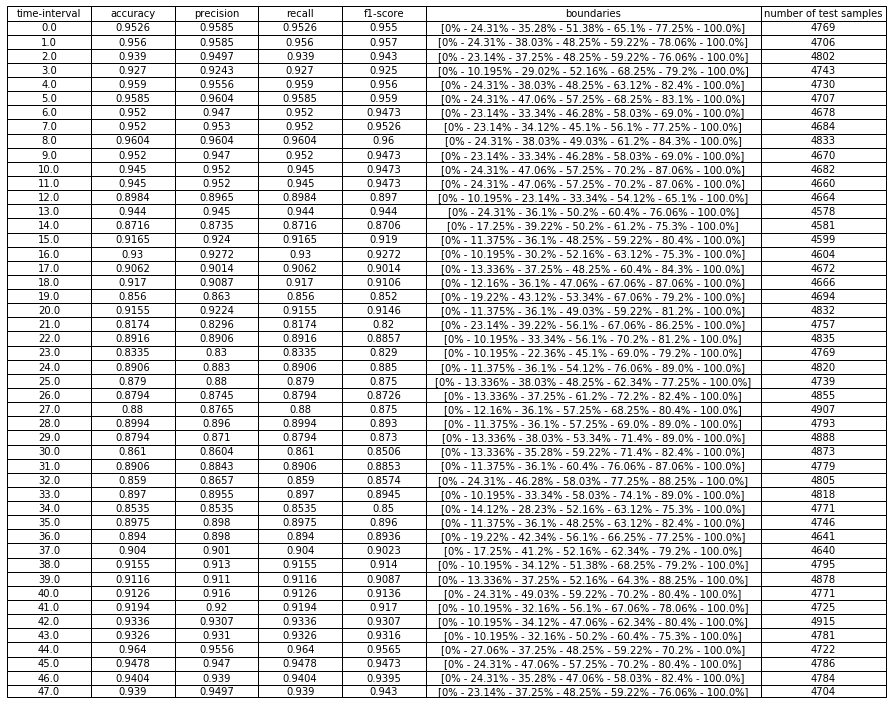

In [908]:
q = a["boundaries"].tolist()

listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
# print(listOfBoundaries)
numberOfTestSamples = [4769, 4706, 4802, 4743, 4730, 4707, 4678, 4684, 4833, 4670, 4682, 
                      4660, 4664, 4578, 4581, 4599, 4604, 4672, 4666, 4694, 4832,
                      4757, 4835, 4769, 4820, 4739, 4855, 4907, 4793, 4888, 4873,
                      4779, 4805, 4818, 4771, 4746, 4641, 4640, 4795, 4878, 4771,
                      4725, 4915, 4781, 4722, 4786, 4784, 4704]
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, a["accuracy"]))
x = np.vstack((x, a["precision"]))
x = np.vstack((x, a["recall"]))
x = np.vstack((x, a["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))
x = np.vstack((x, numberOfTestSamples))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score', 'boundaries', 
                                'number of test samples'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4, 0.15],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,7):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("30min-6class-lr-noPenalty-accuracy.svg", format="svg")
plt.show(the_table)

In [169]:
resultDataFrameNoPenalty["boundaries"].loc[0]

array([ 23.1372549 ,  34.11764706,  50.19607843,  64.31372549,
        76.07843137,  92.15686275, 100.        ])

# 5 Classes

In [80]:
name = "/home/sepehr/thesis/APDataML/5normalBoundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [81]:
normalLumping[0]

[(1.0,
  43.761962890625,
  array([[0.83597884, 0.        , 0.        , 0.        , 0.        ],
         [0.33333333, 0.23958333, 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.2       , 0.        , 0.        ],
         [0.33333333, 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]]),
  [-1, 19, 43, 61, 67, 79])]

In [82]:
percentageArray = []
for i in range(48):
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [741]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

resultDataFrameNoPenalty_30min_6class = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_30min_6class = resultDataFrameNoPenalty.astype('object')

In [742]:
warnings.filterwarnings('ignore')
for timeIndex in range(48):
    if len(normalLumping[timeIndex]) == 0:
        continue
    print(normalLumping[timeIndex][0][3])
    
    print(timeIndex)
#     normalLumping[timeIndex][0][3][-1] = normalLumping[timeIndex][0][3][-1] - 1
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
#         print(bound)
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)

    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)

    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_30min_6class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]


[-1, 19, 43, 61, 67, 79]
0
[ 24.31372549  48.23529412  66.2745098   77.25490196 100.        ]
start training set generation
19075
4769
starting tensor
Initialized
epoch  0 0.9005872483221476 23.13558796588205
epoch  20 0.9613045302013423 6.35902541975847
epoch  40 0.9613569630872483 6.2735709459989675
epoch  60 0.9612520973154363 6.102863589789247
epoch  80 0.962143456375839 6.063875833213727
epoch  100 0.9612520973154363 6.025625280585867
epoch  120 0.9619337248322147 6.0910609663532895
epoch  140 0.962300755033557 6.043386647565255
epoch  160 0.9623531879194631 5.998933973728411
epoch  180 0.9617764261744967 6.034993753537237
epoch  200 0.9619861577181208 5.989801018230068
epoch  220 0.9620910234899329 6.000249520044197
epoch  240 0.9620910234899329 6.016261806424029
[-1, 19, 34, 51, 67, 69]
1
[ 24.31372549  39.21568627  56.07843137  78.03921569 100.        ]
start training set generation
18820
4706
starting tensor
Initialized
epoch  0 0.8960459183673469 24.76766621823214
epoch  20 0

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



[-1, 20, 43, 56, 63, 64]
5
[ 24.31372549  47.05882353  60.39215686  83.1372549  100.        ]
start training set generation
18826
4707
starting tensor
Initialized
epoch  0 0.9050807823129252 21.493378369986605
epoch  20 0.9649234693877551 5.772900831334445
epoch  40 0.9648171768707483 5.677117009248052
epoch  60 0.9653486394557823 5.792025545421911
epoch  80 0.9658269557823129 5.605234909017067
epoch  100 0.9645514455782312 5.675995424845998
epoch  120 0.9651892006802721 5.630461288755441
epoch  140 0.9650297619047619 5.625550692786975
epoch  160 0.9660395408163265 5.579770930466198
epoch  180 0.9654017857142857 5.534476300080614
epoch  200 0.9654017857142857 5.619736987311822
epoch  220 0.9668898809523809 5.513801361731932
epoch  240 0.9656143707482994 5.517683831201929
epoch  260 0.9658269557823129 5.550887482810994
epoch  280 0.96609268707483 5.479783074385455
[-1, 20, 41, 50, 51, 53]
7
[ 24.31372549  45.09803922  56.07843137  77.25490196 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 19, 44, 52, 53, 57]
10
[ 24.31372549  49.01960784  70.19607843  87.05882353 100.        ]
start training set generation
18725
4682
starting tensor
Initialized
epoch  0 0.8932470034246576 22.71319659360469
epoch  20 0.9568707191780822 6.8426003047864725
epoch  40 0.9585295376712328 6.722606498697035
epoch  60 0.9576733732876712 6.7009130802056545
epoch  80 0.95703125 6.636067274090361
epoch  100 0.9578874143835616 6.563093608576957
epoch  120 0.9591716609589042 6.539041955177098
epoch  140 0.9585830479452054 6.6240389643058375
epoch  160 0.9587435787671232 6.623089299218295
epoch  180 0.9583154965753424 6.589085505025029
epoch  200 0.9588505993150684 6.555359904488471


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 6, 28, 50, 62, 65]
13
[ 10.19607843  32.15686275  54.11764706  75.29411765 100.        ]
start training set generation
18308
4578
starting tensor
Initialized
epoch  0 0.8805725524475524 20.019452493507526
epoch  20 0.9358063811188811 10.362402968473374
epoch  40 0.9366258741258742 10.088522732257847
epoch  60 0.9381009615384616 9.937540733730877
epoch  80 0.9365166083916084 9.949935774703123
epoch  100 0.9387565559440559 9.74609635176359
epoch  120 0.9361888111888111 9.820171713829035
epoch  140 0.9373907342657343 9.75598677054986
epoch  160 0.9384287587412588 9.680663273051069
epoch  180 0.9376092657342657 9.692624665640453
epoch  200 0.9379370629370629 9.643896345492012
epoch  220 0.9376092657342657 9.747900170462946


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 19, 34, 47, 67, 80]
14
[ 24.31372549  39.21568627  52.15686275  75.29411765 100.        ]
start training set generation
18322
4581
starting tensor
Initialized
epoch  0 0.8502513111888111 32.404706761553555
epoch  20 0.9294689685314685 11.390377303937099
epoch  40 0.9328015734265734 10.805875318033719
epoch  60 0.9331293706293706 10.664210898059224
epoch  80 0.9323098776223776 10.638240745851206
epoch  100 0.9329108391608392 10.581871947208485
epoch  120 0.9338942307692307 10.553112529791319
epoch  140 0.9359156468531469 10.62206972062171
epoch  160 0.9328562062937062 10.44154682859674
epoch  180 0.9343859265734266 10.40034528170432
epoch  200 0.9350961538461539 10.493961070800994
epoch  220 0.932965472027972 10.486353048077834
epoch  240 0.9356971153846154 10.399065797145546
epoch  260 0.9344951923076923 10.523762299047478
epoch  280 0.9340581293706294 10.355094776286942
epoch  300 0.9335118006993007 10.377373236876267
epoch  320 0.9336756993006993 10.334589320462896
epoch  340 0.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 7, 32, 52, 76, 80]
15
[ 11.37254902  36.07843137  56.07843137  80.39215686 100.        ]
start training set generation
18394
4599
starting tensor
Initialized
epoch  0 0.876088850174216 22.816179629402292
epoch  20 0.9271014808362369 11.47371821951783
epoch  40 0.928734756097561 11.167823533978607
epoch  60 0.9288980836236934 11.082179633582514
epoch  80 0.9293880662020906 11.076286679360924
epoch  100 0.929006968641115 11.035004398133289
epoch  120 0.9288980836236934 11.067784134103865
epoch  140 0.9296058362369338 10.935131190961249
epoch  160 0.9296602787456446 10.889196743117802
epoch  180 0.930640243902439 10.906241259093067
epoch  200 0.9284081010452961 10.922617218635638
epoch  220 0.9305313588850174 10.83564500858559
[-1, 11, 35, 54, 70, 77]
16
[ 16.07843137  40.39215686  59.21568627  75.29411765 100.        ]
start training set generation
18412
4604
starting tensor
Initialized
epoch  0 0.8194141986062717 34.85282407820429
epoch  20 0.9006968641114983 15.791207127454804
epo

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 8, 33, 55, 77, 82]
17
[ 13.33333333  38.03921569  60.39215686  84.31372549 100.        ]
start training set generation
18687
4672
starting tensor
Initialized
epoch  0 0.8610395189003437 25.873681809074686
epoch  20 0.9199957044673539 13.074731558049258
epoch  40 0.9233784364261168 12.692846540732893
epoch  60 0.9225193298969072 12.768082440104276
epoch  80 0.9230562714776632 12.771158808285424
epoch  100 0.921338058419244 12.767299585735676
epoch  120 0.9227341065292096 12.649823044583561
epoch  140 0.9231636597938144 12.564653113945248
epoch  160 0.9223045532646048 12.76291177526782
epoch  180 0.9228414948453608 12.703767394691805
epoch  200 0.922411941580756 12.674207054052976
epoch  220 0.9233247422680413 12.471754132267538
epoch  240 0.9217676116838488 12.738487691813727
epoch  260 0.9221434707903781 12.669034848098487
[-1, 14, 38, 61, 78, 80]
18
[ 19.21568627  43.1372549   66.2745098   87.05882353 100.        ]
start training set generation
18660
4666
starting tensor
Initiali

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 5, 30, 51, 70, 85]
25
[ 11.37254902  36.07843137  57.25490196  76.07843137 100.        ]
start training set generation
18953
4739
starting tensor
Initialized
epoch  0 0.8434860641891891 28.17887382893951
epoch  20 0.9027132601351351 15.133557707876772
epoch  40 0.9048775337837838 14.712823687372987
epoch  60 0.9040329391891891 14.653105776052218
epoch  80 0.9051414695945946 14.557175149788728
epoch  100 0.9065139358108109 14.507074304529139
epoch  120 0.9054054054054054 14.49002032666593
epoch  140 0.9060916385135135 14.635767957648715
epoch  160 0.9061972128378378 14.530809784257734
epoch  180 0.9049831081081081 14.640864668665705
epoch  200 0.9058804898648649 14.552540601910772
[-1, 7, 31, 55, 75, 86]
26
[ 13.33333333  37.25490196  61.17647059  81.17647059 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19420
4855
starting tensor
Initialized
epoch  0 0.8272999174917491 31.644822104929297
epoch  20 0.88871699669967 17.643951998292017
epoch  40 0.8896967821782178 17.30386414701003
epoch  60 0.8903671617161716 16.982643775814044
epoch  80 0.8902640264026402 17.024032800504493
epoch  100 0.8897483498349835 16.95181030330092
epoch  120 0.8908312706270627 16.901955115126302
epoch  140 0.8922751650165016 16.869179741384173
epoch  160 0.8913469471947195 16.870480874190626
epoch  180 0.8880981848184818 17.038553448793518
epoch  200 0.8917079207920792 16.755208895151366
epoch  220 0.8916047854785478 16.82413137234476
epoch  240 0.8907281353135313 16.80934383373448
epoch  260 0.8899546204620462 16.88332996746101


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 6, 30, 52, 74, 86]
27
[ 12.15686275  36.07843137  58.03921569  80.39215686 100.        ]
start training set generation
19624
4907
starting tensor
Initialized
epoch  0 0.801062091503268 34.72944737104034
epoch  20 0.8753063725490197 18.951149650648524
epoch  40 0.8761744281045751 18.639588200188925
epoch  60 0.8764297385620915 18.523110663968737
epoch  80 0.8775531045751634 18.48028897304161
epoch  100 0.8760723039215687 18.388696114222196
epoch  120 0.8759701797385621 18.347368492799646
epoch  140 0.8765318627450981 18.35207078659457
epoch  160 0.8779105392156863 18.362674713134755
epoch  180 0.8749489379084967 18.381165002685762
epoch  200 0.877859477124183 18.307417512719134
epoch  220 0.8759701797385621 18.388015379313533
epoch  240 0.8768892973856209 18.455347413331083
epoch  260 0.8766850490196079 18.231448951110337
epoch  280 0.8752553104575164 18.388910122167033
epoch  300 0.8759701797385621 18.40778862105476
epoch  320 0.8771956699346405 18.196148292691113
epoch  340 0.876

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 16, 38, 62, 82, 84]
28
[ 23.1372549   45.09803922  69.01960784  89.01960784 100.        ]
start training set generation
19170
4793
starting tensor
Initialized
epoch  0 0.7311872909698997 47.14150438340611
epoch  20 0.8562395484949833 21.558312125827946
epoch  40 0.8569188963210702 21.125383450434764
epoch  60 0.8564485785953178 20.927689794712656
epoch  80 0.8558214882943144 21.068415319640497
epoch  100 0.8548808528428093 21.02635928061496
epoch  120 0.8558214882943144 20.839836745756525
epoch  140 0.8556647157190636 20.80537741479269
epoch  160 0.8537834448160535 20.93651287053341


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 7, 32, 56, 73, 87]
29
[ 13.33333333  38.03921569  62.35294118  79.21568627 100.        ]
start training set generation
19549
4888
starting tensor
Initialized
epoch  0 0.8103483606557377 32.60630650754836
epoch  20 0.8843237704918033 17.83237088469207
epoch  40 0.8874487704918033 17.089648876815563
epoch  60 0.8853483606557377 16.94878304590944
epoch  80 0.8872438524590164 16.927579251273738
epoch  100 0.8885245901639345 16.787284400814862
epoch  120 0.8894979508196721 16.73244284801795
epoch  140 0.8882172131147541 16.840730302841937
epoch  160 0.890061475409836 16.635130472652268
epoch  180 0.889344262295082 16.62126739845901
epoch  200 0.8878073770491803 16.639668311447394
epoch  220 0.8887295081967214 16.661071247350982
epoch  240 0.8893954918032787 16.5957817765533
epoch  260 0.8881659836065574 16.634182384365893
epoch  280 0.8891393442622951 16.5931676098558
epoch  300 0.8903176229508196 16.65951598276858
epoch  320 0.8881659836065574 16.64693652606401
epoch  340 0.8885245901

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 6, 31, 55, 76, 87]
33
[ 11.37254902  36.07843137  60.39215686  81.17647059 100.        ]
start training set generation
19269
4818
starting tensor
Initialized
epoch  0 0.8270348837209303 30.256759513652195
epoch  20 0.895296926910299 16.110813250177326
epoch  40 0.8979443521594684 15.607231761133948
epoch  60 0.8979962624584718 15.523583806630384
epoch  80 0.8992940199335548 15.467751316057884
epoch  100 0.8978405315614618 15.591859817504883
epoch  120 0.8981000830564784 15.504521129139238
epoch  140 0.898515365448505 15.457631595903061
epoch  160 0.8976328903654485 15.532432122087954
epoch  180 0.8980481727574751 15.511010236518327
[-1, 10, 24, 48, 71, 90]
34
[ 14.11764706  28.23529412  52.15686275  75.29411765 100.        ]
start training set generation
19083
4771
starting tensor
Initialized
epoch  0 0.733011744966443 44.73230969985858
epoch  20 0.8498846476510067 22.507936004024224
epoch  40 0.8557571308724832 21.613322536417297
epoch  60 0.8560192953020134 21.33806859406848
epo

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 5, 29, 52, 74, 86]
38
[ 10.19607843  34.11764706  57.25490196  79.21568627 100.        ]
start training set generation
19177
4795
starting tensor
Initialized
epoch  0 0.8687290969899666 24.524630575275747
epoch  20 0.9213001672240803 12.682024352127891
epoch  40 0.9204640468227425 12.691944099987627
epoch  60 0.9219272575250836 12.314507856018169
epoch  80 0.921875 12.287977016889139
epoch  100 0.9225543478260869 12.212375411221812
epoch  120 0.9231291806020067 12.20994007467825
epoch  140 0.9229724080267558 12.187658023674754
epoch  160 0.9233382107023411 12.228488163804528
[-1, 9, 33, 57, 81, 87]
39
[ 14.11764706  38.03921569  62.35294118  87.05882353 100.        ]
start training set generation
19512
4878
starting tensor
Initialized
epoch  0 0.8284333881578947 31.631450725229193
epoch  20 0.9128803453947368 14.234710487880207
epoch  40 0.9137541118421053 13.894311054756766
epoch  60 0.9137027138157895 13.746267483422633
epoch  80 0.9164782072368421 13.636668870323586
epoch  100 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 19, 44, 61, 70, 78]
41
[ 24.31372549  49.01960784  66.2745098   78.03921569 100.        ]
start training set generation
18898
4725
starting tensor
Initialized
epoch  0 0.8432203389830508 31.281565588611663
epoch  20 0.9260063559322034 11.667798890905866
epoch  40 0.9263771186440678 11.594994612871588
epoch  60 0.9264300847457627 11.328670986628138
epoch  80 0.9263771186440678 11.362608068272216
epoch  100 0.9283368644067796 11.177653373297998
epoch  120 0.9278601694915254 11.121529392064627


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 13, 35, 59, 73, 74]
42
[ 17.25490196  39.21568627  63.1372549   80.39215686 100.        ]
start training set generation
19660
4915
starting tensor
Initialized
epoch  0 0.7886298859934854 36.860456730721445
epoch  20 0.9009568403908795 15.378478377960404
epoch  40 0.9029417752442996 15.084491297942419
epoch  60 0.9021274429967426 14.948155274220321
epoch  80 0.9017711726384365 14.95611723393493
epoch  100 0.9020765472312704 14.936491021892536
epoch  120 0.9021274429967426 14.9372921968516
epoch  140 0.9023310260586319 14.897565141174615
epoch  160 0.9029417752442996 15.062627824975923
[-1, 20, 41, 57, 67, 71]
43
[ 24.31372549  45.09803922  61.17647059  75.29411765 100.        ]
start training set generation
19124
4781
starting tensor
Initialized
epoch  0 0.8657193791946308 28.3875356456577
epoch  20 0.9387583892617449 9.430928639117507
epoch  40 0.9404362416107382 9.42547111543233
epoch  60 0.94001677852349 9.158148904774805
epoch  80 0.9420616610738255 9.054657276844816
epoch  100

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19144
4786
starting tensor
Initialized
epoch  0 0.881061872909699 20.131524503829084
epoch  20 0.9412102842809364 10.060009010659416
epoch  40 0.9394335284280937 9.810655338309683
epoch  60 0.9404264214046822 9.671899070309149
epoch  80 0.9399038461538461 9.67942805433752
epoch  100 0.9405309364548495 9.61820605088237
epoch  120 0.940060618729097 9.567976489912306
epoch  140 0.9412102842809364 9.588693694526137
epoch  160 0.9407922240802675 9.538429770182601
epoch  180 0.9401128762541806 9.53419452048465
epoch  200 0.941001254180602 9.641931568101096
epoch  220 0.9414715719063546 9.528473358090508
epoch  240 0.9403219063545151 9.585951091453781
epoch  260 0.9411057692307693 9.50031488436121
epoch  280 0.9417851170568562 9.439605708106308
epoch  300 0.9417328595317725 9.438278012451123
epoch  320 0.9398515886287625 9.525360719814751


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[-1, 20, 43, 54, 64, 68]
46
[ 24.31372549  47.05882353  58.03921569  82.35294118 100.        ]
start training set generation
19132
4784
starting tensor
Initialized
epoch  0 0.8851719798657718 25.380566187352944
epoch  20 0.9556942114093959 7.365827675233751
epoch  40 0.954330956375839 7.1716365070151005
epoch  60 0.954488255033557 7.232650807439879
epoch  80 0.9548552852348994 7.083898932541777
epoch  100 0.9542785234899329 7.145646685121844
epoch  120 0.954488255033557 7.280787297743277
epoch  140 0.9548552852348994 7.163028298608409
[-1, 20, 45, 59, 67, 69]
47
[ 24.31372549  49.01960784  65.09803922  83.1372549  100.        ]
start training set generation
0
0
starting tensor
Initialized


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



ZeroDivisionError: division by zero

In [952]:
resultDataFrameNoPenalty_30min_6class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError,wieghts
0,0.965821,13.8384,0.963338,0.965821,0.963941,"[24.31372549019606, 48.23529411764696, 66.2745098039214, 77.25490196078411, 100.0]",1,43.762,inf
1,0.959414,6.83429,0.958504,0.959414,0.958774,"[24.31372549019606, 39.215686274509736, 56.07843137254889, 78.0392156862743, 100.0]",1,32.4324,inf
2,0.963557,10.1462,0.965146,0.963557,0.964175,"[24.31372549019606, 47.05882352941167, 59.215686274509665, 76.07843137254882, 100.0]",1,23.4868,inf
3,0.927894,17.4439,0.929704,0.927894,0.927766,"[10.196078431372554, 34.11764705882348, 56.07843137254889, 79.2156862745096, 100.0]",0.75,22.717,inf
4,0.959619,8.81163,0.960596,0.959619,0.959314,"[24.31372549019606, 42.35294117647051, 63.13725490196063, 82.35294117647037, 100.0]",1,32.0817,inf
5,0.957935,10.8647,0.961213,0.957935,0.959098,"[24.31372549019606, 47.05882352941167, 60.392156862744955, 83.13725490196056, 100.0]",1,34.1016,inf
6,0.953613,4.34837,0.948129,0.953613,0.948548,"[23.13725490196077, 33.333333333333286, 46.274509803921475, 58.039215686274375, 63.1372549019606...",1,22.756,inf
7,0.961785,8.01601,0.965623,0.961785,0.96307,"[24.31372549019606, 45.098039215686185, 56.07843137254889, 77.25490196078411, 100.0]",0.75,19.1238,inf
8,0.961308,12.3655,0.96349,0.961308,0.962218,"[24.31372549019606, 49.01960784313715, 61.17647058823515, 84.31372549019585, 100.0]",1,31.2584,inf
9,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [910]:
# resultDataFrameNoPenalty_30min_6class.to_pickle("5class_LR_noPenalty_normal.pickle")

In [62]:
resultDataFrameNoPenalty_30min_6class = pd.read_pickle("6class_LR_noPenalty_normal.pickle")

## Getting Importance of Features

In [117]:
def dataPreparationForLR(data, timeIndexes, minuteSplit, boundaries):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    x = timeIndexes
    wholeDataFrame = data.loc[(data["timeIndex"] == x)].copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    prevCUVal = 1
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = 48 + len(boundaries) + 1
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    wholeDataFrame.reset_index()
    for index, row in wholeDataFrame.iterrows():
#         if (index + steps) not in wholeDataFrame.index:
#             continue
#         booleanCont = 0
#         for stationary in range(1, 48):
#             if (index - stationary*steps) not in wholeDataFrame.index:
#                 booleanCont = 1
#                 continue
#         if booleanCont == 1:
#             continue
            
#         XArraysForLearning[pandasIndexCounter, 0] = row["normalLogDiff"]
#         for stationary in range(1, 48):
#                 XArraysForLearning[pandasIndexCounter, stationary] = wholeDataFrame.loc[index - stationary*steps]["normalLogDiff"]
                

#         XArraysForLearning[pandasIndexCounter, 48 + wholeDataFrame.loc[index - steps]["cuClass"]] = 1
#         XArraysForLearning[pandasIndexCounter, 48 + len(boundaries) + row["cuClass"]] = 1
#         XArraysForLearning[pandasIndexCounter, 48 + 2 * len(boundaries)] = (wholeDataFrame.loc[index - steps]["CU"]/255)
#         XArraysForLearning[pandasIndexCounter, 48 + 2 * len(boundaries) + 1] = (row["CU"] / 255)
        XArraysForLearning[pandasIndexCounter, prevCU] = 1
        for corrs in range(48):
            XArraysForLearning[pandasIndexCounter, (len(boundaries)) + corrs] = row["corr" + str(corrs + 1)]
        XArraysForLearning[pandasIndexCounter, 48 + len(boundaries)] = row["normalLogDiff"]
        
        
            
#         diffLogValue = (np.log(row["CU"]) - np.log(wholeDataFrame.loc[index - steps]["CU"]))/ (np.log(255) - np.log(1))
        YArraysForLearning[pandasIndexCounter, wholeDataFrame.loc[index]["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        prevCUVal = row["CU"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries


In [127]:
warnings.filterwarnings('ignore')
for timeIndex in range(48):
    timeIndex = 1
    if len(normalLumping[timeIndex]) == 0:
        continue
    print(normalLumping[timeIndex][0][3])
    
    print(timeIndex)
#     normalLumping[timeIndex][0][3][-1] = normalLumping[timeIndex][0][3][-1] - 1
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
#         print(bound)
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)

    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparationForLR(
        data, timeIndex, 30, boundaries)

    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 10000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
#     X = np.argmax(XArraysForLearning, axis = 1)
    Y = np.argmax(YArraysForLearning, axis = 1)
    Yhat = np.argmax(YArraysForTesting, axis = 1)
    clf.fit(XArraysForLearning,Y)
    a = clf.predict(XArraysForTesting)
    print(accuracy_score(a, Yhat))
#     print(clf.score(a, Yhat))

    break

[-1, 19, 33, 43, 53, 67, 69]
1
[ 24.31372549  38.03921569  48.23529412  59.21568627  78.03921569
 100.        ]
start training set generation
18820
4706
0.956651083722907


In [119]:
clf.coef_[1].shape

(55,)

## Making Feature Importance Table

/home/sepehr/.local/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.

/home/sepehr/.local/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.

/home/sepehr/.local/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.

/home/sepehr/.local/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

7.555084962657597 -13.098400605298435


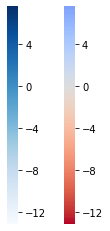

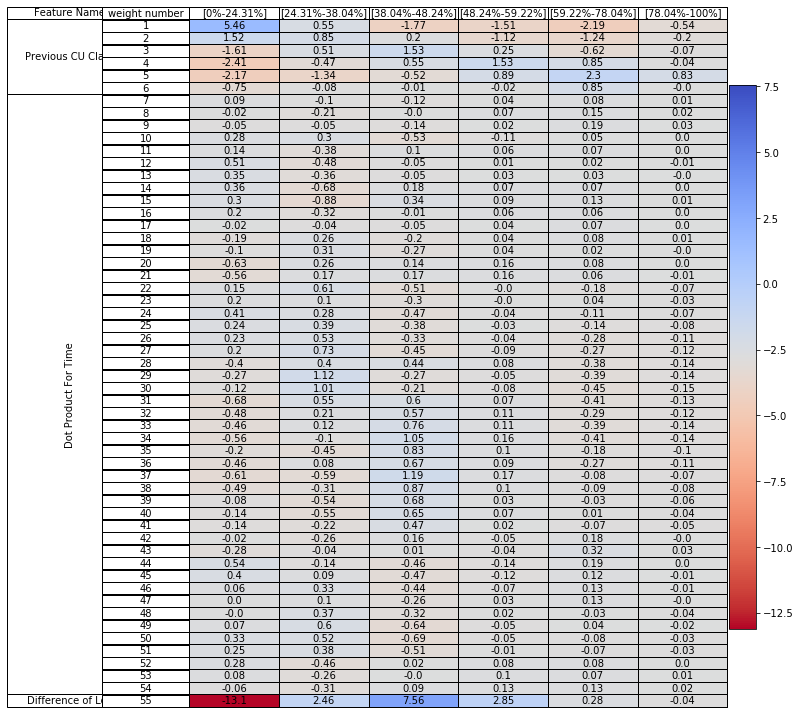

In [129]:
import seaborn as sns;
# warnings.filterwarnings('ignore')
# for timeIndex in range(48):
#     timeIndex = 1
#     if len(normalLumping[timeIndex]) == 0:
#         continue
#     print(normalLumping[timeIndex][0][3])
    
#     print(timeIndex)
# #     normalLumping[timeIndex][0][3][-1] = normalLumping[timeIndex][0][3][-1] - 1
#     boundaries = np.array([])
#     for i in range(1, len(normalLumping[0][0][3])):
#         bound = normalLumping[timeIndex][0][3][i] + 1
# #         print(bound)
#         counter = 0
#         for j in range(len(percentageArray[timeIndex])):
#             if percentageArray[timeIndex][j][2] == False:
#                 counter += 1
#             if counter == bound:
#                 boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
#                 break
#     boundaries = np.append(boundaries,100)

#     print(boundaries)
    
#     XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
#         data, timeIndex, 30, boundaries, 1)

#     reg = "l2"
#     solvers = "lbfgs"
#     clf = LogisticRegression(penalty = reg, max_iter = 10000, random_state = 0,
#                              solver = solvers , multi_class = 'multinomial')
# #     X = np.argmax(XArraysForLearning, axis = 1)
#     Y = np.argmax(YArraysForLearning, axis = 1)
#     Yhat = np.argmax(YArraysForTesting, axis = 1)
#     clf.fit(XArraysForLearning,Y)
#     a = clf.predict(XArraysForTesting)
#     print(accuracy_score(a, Yhat))
# #     print(clf.score(a, Yhat))

#     break

maximum = 0
minimum = 0
for i in range(len(clf.coef_)):
    if max(clf.coef_[i]) > maximum:
        maximum = max(clf.coef_[i])
    if min(clf.coef_[i]) < minimum:
        minimum = min(clf.coef_[i])

plt.gca().set_visible(False)        
ax = sns.heatmap(clf.coef_, center=0, vmin=minimum, vmax=maximum, cmap="coolwarm_r", robust=False)
ax.collections[0].set_alpha(1)
im = ax.collections[0]
hm = sns.heatmap(clf.coef_, cmap=cmap)
rgba_values = im.cmap(im.norm(clf.coef_))
        
print(maximum, minimum)
totalRange= np.abs(maximum) + np.abs(minimum)

fig = plt.figure(figsize=(15,10))
plt.axis('off')
plt.axis('tight')
ax = fig.add_subplot(111)
time = [i for i in range(55)]
x = np.array([])
x = np.append(x, time)
aaa = np.around(clf.coef_, decimals = 2)
x = np.vstack((x, aaa))
# ax=fig.gca()
# ax.axis('off')



header_0 = plt.table(cellText=[["Feature Name"]],
#                      colLabels=['weight number'],
                     colWidths = [0.4],
                     loc='top',
                     cellLoc='center',
                     bbox=[-0.25, 1.121, 0.23, 0.023]
                     )
header_1 = plt.table(cellText=[['Previous CU Class']],
#                      colLabels=['weight number'],
                     loc='top',
                     cellLoc='center',
                     bbox=[-0.25, 0.983, 0.23, 0.138]
                     )
header_2 = plt.table(cellText=[['Dot Product For Time']],
#                      colLabels=['weight number'],
                     loc='top',
                     colWidths=[1],
                     cellLoc='center',
                     bbox=[-0.25, -0.121, 0.23, 1.104]
                     )
header_3 = plt.table(cellText=[['Difference of Log']],
#                      colLabels=['weight number'],
                     loc='top',
                     cellLoc='center',
                     bbox=[-0.25, -0.144, 0.23, 0.023]
                     )
the_table = plt.table(cellText=x.T.astype(np.float16),
#                       rowLabels=rows,
                      colLabels=['weight number','[0%-24.31%]','[24.31%-38.04%]', '[38.04%-48.24%]', '[48.24%-59.22%]', '[59.22%-78.04%]', '[78.04%-100%]'],
                      colWidths=[0.16,0.165,0.165,0.165,0.165,0.165,0.165],
                      cellLoc='center',
                      loc='center'
                     )
# 24.31372549  38.03921569  48.23529412  59.21568627  78.03921569
for cell in header_2._cells:
    if cell[0] ==0:
        header_2._cells[cell].get_text().set_rotation(90)
        header_2._cells[cell].set_width(1)
        
the_table.auto_set_font_size(False)
header_0.auto_set_font_size(True)
header_1.auto_set_font_size(True)
header_2.auto_set_font_size(True)
header_3.auto_set_font_size(True)
the_table.set_fontsize(10)
header_0.set_fontsize(10)
header_1.set_fontsize(10)
header_2.set_fontsize(10)
header_3.set_fontsize(10)

cellDict = the_table.get_celld()
for i in range(1, 56):
    a = float(cellDict[(i,0)].get_text().get_text())
    cellDict[(i,0)].get_text().set_text(int(a) + 1)
for i in range(1,7):
    cellDict[(0,i)].set_height(0.023)
    for j in range(1,56):
        cellDict[(j,i)].set_height(0.023)
        a = float(cellDict[(j,i)].get_text().get_text())
#         print(num_to_rgb(a+(17.605324452591265), 50))
        cellDict[(j,i)].set_facecolor(rgba_values[i-1][j-1])
ax.add_table(the_table)
img = plt.imshow(np.array([[minimum,maximum]]), cmap="coolwarm_r")
# img.figure(figsize=(1,1))
img.set_visible(False)

plt.colorbar(orientation="vertical")    
# plt.colorbar(cax=[minimum, maximum])

plt.savefig("feature_analysis_idle-hours.svg", format="svg")
plt.show(the_table)

In [335]:
dir(sns.heatmap.__class__)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [103]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
cmap = cm.get_cmap('Blues')
hm = sns.heatmap(clf.coef_, cmap=cmap)
norm = Normalize(vmin=clf.coef_.min(), vmax=clf.coef_.max())
rgba_values = cmap(norm(clf.coef_))
# ax = sns.heatmap(clf.coef_, center=0, cmap="Blues", robust=False)
# im = ax.collections[0]
# rgba_values = im.cmap(im.norm(clf.coef_))

NameError: name 'sns' is not defined

In [232]:
len(rgba_values)

6

In [186]:
def num_to_rgb(val, max_val):
    if (val > max_val):
        raise ValueError("val must not be greater than max_val", val, max_val)
    if (val < 0 or max_val < 0):
        raise ValueError("arguments may not be negative", val, max_val)

    i = (val * 255 / max_val);
    r = round(math.sin(0.024 * i + 0) * 127 + 128);
    g = round(math.sin(0.024 * i + 2) * 127 + 128);
    b = round(math.sin(0.024 * i + 4) * 127 + 128);
    
    minRGB = min(r,g,b)
    alpha = (255-minRGB)/255
    newR = (r - minRGB)/alpha
    newG = (g - minRGB)/alpha
    newB = (b - minRGB)/alpha
    
    return (newR/256, newG/256, newB/256, alpha/1.25)

In [163]:
import matplotlib as m
cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

In [180]:
cm(-1,255,255)

(63, 0, 255, 255)

In [549]:
resultDataFrameNoPenalty_30min_6class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError,wieghts
0,0.871881,40.9747,0.870655,0.871881,0.869853,"[24.31372549019606, 35.29411764705877, 51.37254901960773, 65.09803921568611, 77.25490196078411, ...",1,40.08,inf
1,0.871881,40.9747,0.870655,0.871881,0.869853,"[24.31372549019606, 38.039215686274446, 48.23529411764696, 59.215686274509665, 78.0392156862743,...",1,29.2262,inf
2,0.871881,40.9747,0.870655,0.871881,0.869853,"[23.13725490196077, 37.25490196078425, 48.23529411764696, 59.215686274509665, 76.07843137254882,...",1,20.4296,inf
3,0.871881,40.9747,0.870655,0.871881,0.869853,"[10.196078431372554, 29.01960784313722, 52.156862745097925, 68.23529411764689, 79.2156862745096,...",0.553711,20.5107,inf
4,0.871881,40.9747,0.870655,0.871881,0.869853,"[24.31372549019606, 38.039215686274446, 48.23529411764696, 63.13725490196063, 82.35294117647037,...",1,31.1744,inf
5,0.871881,40.9747,0.870655,0.871881,0.869853,"[24.31372549019606, 47.05882352941167, 57.25490196078418, 68.23529411764689, 83.13725490196056, ...",1,30.1017,inf
6,0.871881,40.9747,0.870655,0.871881,0.869853,"[23.13725490196077, 33.333333333333286, 46.274509803921475, 58.039215686274375, 69.0196078431370...",1,22.756,inf
7,0.871881,40.9747,0.870655,0.871881,0.869853,"[23.13725490196077, 34.11764705882348, 45.098039215686185, 56.07843137254889, 77.25490196078411,...",0.75,18.2521,inf
8,0.871881,40.9747,0.870655,0.871881,0.869853,"[24.31372549019606, 38.039215686274446, 49.01960784313715, 61.17647058823515, 84.31372549019585,...",1,28.1196,inf
9,0.957935,10.8647,0.961213,0.957935,0.959098,"[24.31372549019606, 47.05882352941167, 60.392156862744955, 69.01960784313708, 71.37254901960766,...",1,34.1016,inf


## Running Naive Model for 5, 6 Classes

In [750]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "precision": precisionResult, "recall": recallResult, 
                 "f1Score": f1ScoreResult, "boundaries": boundariesResult, "lumpAprox": lumpAproxResult, 
                 "lumpError": lumpErrorResult}

naiveDataFrameNoPenalty_30min_6class = pd.DataFrame(testDataFrame)
naiveDataFrameNoPenalty_30min_6class = naiveDataFrameNoPenalty_30min_6class.astype('object')

In [752]:
warnings.filterwarnings('ignore')
for timeIndex in range(47):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
#     normalLumping[timeIndex][0][3][-1] = normalLumping[timeIndex][0][3][-1] - 1
    boundaries = np.array([])
    for i in range(1, len(normalLumping[timeIndex][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
#         print(bound)
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[naiveDataFrameNoPenalty_30min_6classmeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)

    print(boundaries)
    
    accuracy_result, precision, recall, f1Score = naive(data, timeIndex, boundaries)
    print(accuracy_result)
    
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["accuracy"] = accuracy_result
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["precision"] = precision
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["recall"] = recall
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["f1Score"] = f1Score
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["boundaries"] = boundaries
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    naiveDataFrameNoPenalty_30min_6class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]


0
[ 24.31372549  35.29411765  51.37254902  65.09803922  77.25490196
 100.        ]
0.9089079013588324
1
[ 24.31372549  38.03921569  48.23529412  59.21568627  78.03921569
 100.        ]
0.9071665391481765
2
[ 23.1372549   37.25490196  48.23529412  59.21568627  76.07843137
 100.        ]
0.884028992751812
3
[ 10.19607843  29.01960784  52.15686275  68.23529412  79.21568627
 100.        ]
0.846932321315623
4
[ 24.31372549  38.03921569  48.23529412  63.1372549   82.35294118
 100.        ]
0.9151338322973487
5
[ 24.31372549  47.05882353  57.25490196  68.23529412  83.1372549
 100.        ]
0.922236858879021
6
[ 23.1372549   33.33333333  46.2745098   58.03921569  69.01960784
 100.        ]
0.8964087216759299
7
[ 23.1372549   34.11764706  45.09803922  56.07843137  77.25490196
 100.        ]
0.8944491887275833
8
[ 24.31372549  38.03921569  49.01960784  61.17647059  84.31372549
 100.        ]
0.9142833491991226
10
[ 24.31372549  47.05882353  57.25490196  70.19607843  87.05882353
 100.        ]
0.

In [50]:
# naiveDataFrameNoPenalty_30min_6class.to_pickle("6class_naive_noPenalty_normal.pickle")
naiveDataFrameNoPenalty_30min_6class = pd.read_pickle("6class_naive_noPenalty_normal.pickle")

In [899]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "precision": precisionResult, "recall": recallResult, 
                 "f1Score": f1ScoreResult, "boundaries": boundariesResult, "lumpAprox": lumpAproxResult, 
                 "lumpError": lumpErrorResult}

naiveDataFrameNoPenalty_30min_5class = pd.DataFrame(testDataFrame)
naiveDataFrameNoPenalty_30min_5class = naiveDataFrameNoPenalty_30min_5class.astype('object')

In [900]:
warnings.filterwarnings('ignore')
for timeIndex in range(47):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
#     normalLumping[timeIndex][0][3][-1] = normalLumping[timeIndex][0][3][-1] - 1
    boundaries = np.array([])
    for i in range(1, len(normalLumping[timeIndex][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
#         print(bound)
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)

    print(boundaries)
    
    accuracy_result, precision, recall, f1Score = naive(data, timeIndex, boundaries)
    print(accuracy_result)
    
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["accuracy"] = accuracy_result
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["precision"] = precision
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["recall"] = recall
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["f1Score"] = f1Score
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["boundaries"] = boundaries
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    naiveDataFrameNoPenalty_30min_5class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]


0
[ 24.31372549  48.23529412  66.2745098   77.25490196 100.        ]
0.916037577587653
1
[ 24.31372549  39.21568627  56.07843137  78.03921569 100.        ]
0.9082291932330188
2
[ 24.31372549  47.05882353  59.21568627  76.07843137 100.        ]
0.9081063067566442
3
[ 10.19607843  34.11764706  56.07843137  79.21568627 100.        ]
0.8674256799493991
4
[ 24.31372549  42.35294118  63.1372549   82.35294118 100.        ]
0.9172903716859064
5
[ 24.31372549  47.05882353  60.39215686  83.1372549  100.        ]
0.9223218459184974
7
[ 24.31372549  45.09803922  56.07843137  77.25490196 100.        ]
0.9204099060631938
8
[ 24.31372549  49.01960784  61.17647059  84.31372549 100.        ]
0.918546417780721
10
[ 24.31372549  49.01960784  70.19607843  87.05882353 100.        ]
0.905498355192891
13
[ 10.19607843  32.15686275  54.11764706  75.29411765 100.        ]
0.8756444988202394
14
[ 24.31372549  39.21568627  52.15686275  75.29411765 100.        ]
0.8504562721040911
15
[ 11.37254902  36.07843137  5

In [761]:
naiveDataFrameNoPenalty_30min_6class

,accuracy,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.908908,0.908908,0.908908,0.908908,"[24.31372549019606, 35.29411764705877, 51.37254901960773, 65.09803921568611, 77.25490196078411, ...",1,40.08
1,0.907167,0.907167,0.907167,0.907167,"[24.31372549019606, 38.039215686274446, 48.23529411764696, 59.215686274509665, 78.0392156862743,...",1,29.2262
2,0.884029,0.884029,0.884029,0.884029,"[23.13725490196077, 37.25490196078425, 48.23529411764696, 59.215686274509665, 76.07843137254882,...",1,20.4296
3,0.846932,0.846941,0.846932,0.846937,"[10.196078431372554, 29.01960784313722, 52.156862745097925, 68.23529411764689, 79.2156862745096,...",0.553711,20.5107
4,0.915134,0.915134,0.915134,0.915134,"[24.31372549019606, 38.039215686274446, 48.23529411764696, 63.13725490196063, 82.35294117647037,...",1,31.1744
5,0.922237,0.922237,0.922237,0.922237,"[24.31372549019606, 47.05882352941167, 57.25490196078418, 68.23529411764689, 83.13725490196056, ...",1,30.1017
6,0.896409,0.896409,0.896409,0.896409,"[23.13725490196077, 33.333333333333286, 46.274509803921475, 58.039215686274375, 69.0196078431370...",1,22.756
7,0.894449,0.894449,0.894449,0.894449,"[23.13725490196077, 34.11764705882348, 45.098039215686185, 56.07843137254889, 77.25490196078411,...",0.75,18.2521
8,0.914283,0.914283,0.914283,0.914283,"[24.31372549019606, 38.039215686274446, 49.01960784313715, 61.17647058823515, 84.31372549019585,...",1,28.1196
9,0.886829,0.886829,0.886829,0.886829,"[23.13725490196077, 46.274509803921475, 54.11764705882341, 56.07843137254889, 57.25490196078418,...",1,23.8296


In [51]:
# naiveDataFrameNoPenalty_30min_5class.to_pickle("5class_naive_noPenalty_normal.pickle")
naiveDataFrameNoPenalty_30min_5class = pd.read_pickle("5class_naive_noPenalty_normal.pickle")

In [980]:
resultDataFrameNoPenalty_30min_5class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError,wieghts
0,0.965821,13.8384,0.963338,0.965821,0.963941,"[24.31372549019606, 48.23529411764696, 66.2745098039214, 77.25490196078411, 100.0]",1,43.762,inf
1,0.959414,6.83429,0.958504,0.959414,0.958774,"[24.31372549019606, 39.215686274509736, 56.07843137254889, 78.0392156862743, 100.0]",1,32.4324,inf
2,0.963557,10.1462,0.965146,0.963557,0.964175,"[24.31372549019606, 47.05882352941167, 59.215686274509665, 76.07843137254882, 100.0]",1,23.4868,inf
3,0.927894,17.4439,0.929704,0.927894,0.927766,"[10.196078431372554, 34.11764705882348, 56.07843137254889, 79.2156862745096, 100.0]",0.75,22.717,inf
4,0.959619,8.81163,0.960596,0.959619,0.959314,"[24.31372549019606, 42.35294117647051, 63.13725490196063, 82.35294117647037, 100.0]",1,32.0817,inf
5,0.957935,10.8647,0.961213,0.957935,0.959098,"[24.31372549019606, 47.05882352941167, 60.392156862744955, 83.13725490196056, 100.0]",1,34.1016,inf
6,0.953613,4.34837,0.948129,0.953613,0.948548,"[23.13725490196077, 33.333333333333286, 46.274509803921475, 58.039215686274375, 63.1372549019606...",1,22.756,inf
7,0.961785,8.01601,0.965623,0.961785,0.96307,"[24.31372549019606, 45.098039215686185, 56.07843137254889, 77.25490196078411, 100.0]",0.75,19.1238,inf
8,0.961308,12.3655,0.96349,0.961308,0.962218,"[24.31372549019606, 49.01960784313715, 61.17647058823515, 84.31372549019585, 100.0]",1,31.2584,inf
9,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [68]:
resultDataFrameNoPenalty1

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.95282,4.16943,0.958517,0.95282,0.955172,"[24.31372549019606, 35.29411764705877, 51.3725...",1,40.08
1,0.956014,4.99328,0.958371,0.956014,0.9569,"[24.31372549019606, 38.039215686274446, 48.235...",1,29.2262
2,0.938984,5.45695,0.949628,0.938984,0.942705,"[23.13725490196077, 37.25490196078425, 48.2352...",1,20.4296
3,0.926629,15.892,0.924551,0.926629,0.92484,"[10.196078431372554, 29.01960784313722, 52.156...",0.553711,20.5107
4,0.958774,5.64826,0.955438,0.958774,0.955859,"[24.31372549019606, 38.039215686274446, 48.235...",1,31.1744
5,0.95836,11.0724,0.960323,0.95836,0.958943,"[24.31372549019606, 47.05882352941167, 57.2549...",1,30.1017
6,0.95233,4.46383,0.946614,0.95233,0.947238,"[23.13725490196077, 33.333333333333286, 46.274...",1,22.756
7,0.952391,3.68332,0.953333,0.952391,0.95263,"[23.13725490196077, 34.11764705882348, 45.0980...",0.75,18.2521
8,0.96048,4.90901,0.960261,0.96048,0.959836,"[24.31372549019606, 38.039215686274446, 49.019...",1,28.1196
9,inf,inf,inf,inf,inf,inf,inf,inf


In [157]:
timeIndex

1

In [144]:
a = resultDataFrameNoPenalty1.copy()
a["boundaries"].loc[6] = a["boundaries"].loc[4]
a.loc[9] = a.loc[6]
a.loc[11] = a.loc[10]
# a.loc[12] = a.loc[24]
a.loc[47] = a.loc[2]
a["boundaries"].loc[44] = a["boundaries"].loc[43]



[array([ 24.31372549,  35.29411765,  51.37254902,  65.09803922,
        77.25490196, 100.        ]), array([ 24.31372549,  38.03921569,  48.23529412,  59.21568627,
        78.03921569, 100.        ]), array([ 23.1372549 ,  37.25490196,  48.23529412,  59.21568627,
        76.07843137, 100.        ]), array([ 10.19607843,  29.01960784,  52.15686275,  68.23529412,
        79.21568627, 100.        ]), array([ 24.31372549,  38.03921569,  48.23529412,  63.1372549 ,
        82.35294118, 100.        ]), array([ 24.31372549,  47.05882353,  57.25490196,  68.23529412,
        83.1372549 , 100.        ]), array([ 24.31372549,  38.03921569,  48.23529412,  63.1372549 ,
        82.35294118, 100.        ]), array([ 23.1372549 ,  34.11764706,  45.09803922,  56.07843137,
        77.25490196, 100.        ]), array([ 24.31372549,  38.03921569,  49.01960784,  61.17647059,
        84.31372549, 100.        ]), array([ 24.31372549,  38.03921569,  48.23529412,  63.1372549 ,
        82.35294118, 100.        ]),

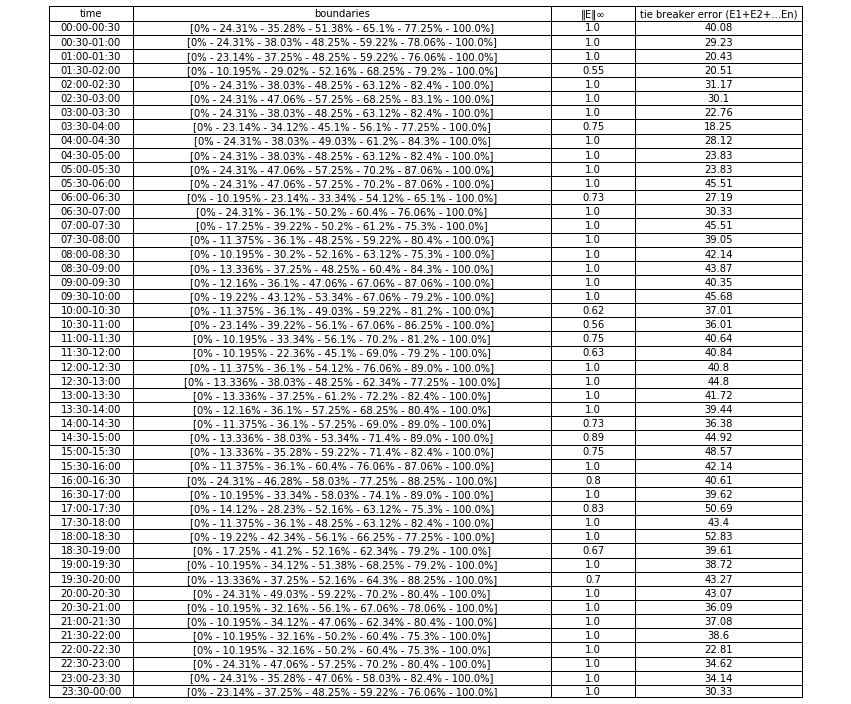

In [159]:
q = a["boundaries"].tolist()
print(q)
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)

print(listOfBoundaries)


time = [int(i) for i in range(48)]

# x = np.array([])
# x = np.append(x, timeIndex)
# x = np.vstack((x, np.around(a["accuracy"].tolist(), decimals=2)))
# x = np.vstack((x, np.around(a["precision"].tolist(), decimals=2)))
# x = np.vstack((x, np.around(a["recall"].tolist(), decimals=2)))
# x = np.vstack((x, np.around(a["f1Score"].tolist(), decimals=2)))

x = np.array([])
x = np.append(x, timeIndex)
x = np.vstack((x, listOfBoundaries))
x = np.vstack((x, np.around(naiveDataFrameNoPenalty_30min_6class["lumpAprox"].tolist(), decimals=2)))
x = np.vstack((x, np.around(naiveDataFrameNoPenalty_30min_6class["lumpError"].tolist(), decimals=2)))

plt.figure(figsize=(15,10))
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','boundaries', '‖E‖∞', 'tie breaker error (E1+E2+...En)'],
                      colWidths=[0.1,0.5,0.1,0.2],
                      cellLoc='center',
                      loc='center')

cellDict = the_table.get_celld()
for i in range(0,4):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
        
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
# plt.savefig("30min-6class-noPenalty-boundaries.svg", format="svg")
plt.show(the_table)

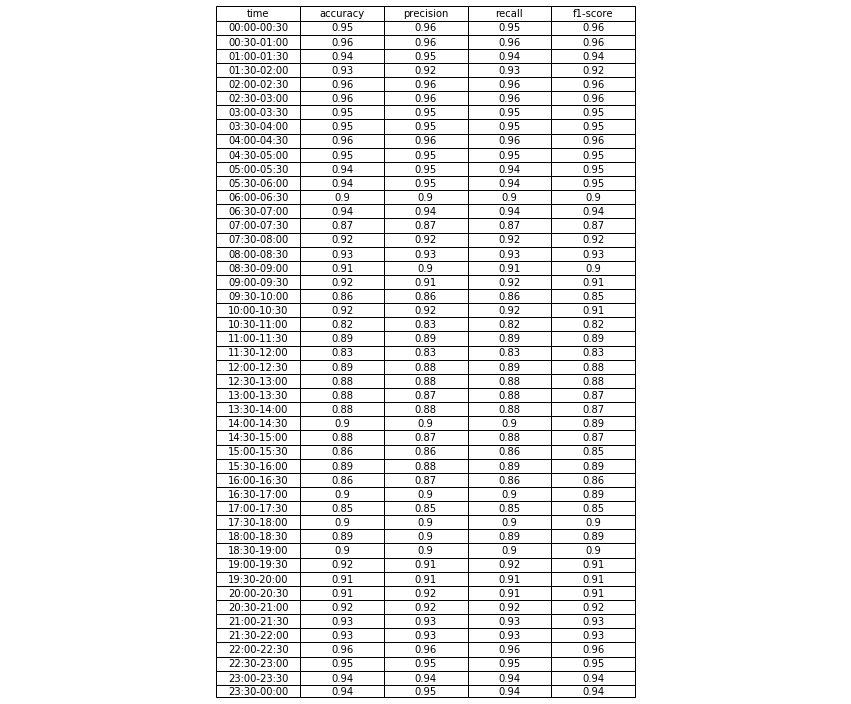

In [160]:
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, timeIndex)
x = np.vstack((x, np.around(a["accuracy"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["precision"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["recall"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["f1Score"].tolist(), decimals=2)))
# x = x.astype(np.float16)

plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,5):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
# plt.savefig("30min-6class-lr-noPenalty-accuracy.svg", format="svg")
plt.show(the_table)

In [138]:
a

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.95282,4.16943,0.958517,0.95282,0.955172,"[24.31372549019606, 35.29411764705877, 51.3725...",1,40.08
1,0.956014,4.99328,0.958371,0.956014,0.9569,"[24.31372549019606, 38.039215686274446, 48.235...",1,29.2262
2,0.938984,5.45695,0.949628,0.938984,0.942705,"[23.13725490196077, 37.25490196078425, 48.2352...",1,20.4296
3,0.926629,15.892,0.924551,0.926629,0.92484,"[10.196078431372554, 29.01960784313722, 52.156...",0.553711,20.5107
4,0.958774,5.64826,0.955438,0.958774,0.955859,"[24.31372549019606, 38.039215686274446, 48.235...",1,31.1744
5,0.95836,11.0724,0.960323,0.95836,0.958943,"[24.31372549019606, 47.05882352941167, 57.2549...",1,30.1017
6,0.95233,4.46383,0.946614,0.95233,0.947238,"[24.31372549019606, 38.039215686274446, 48.235...",1,22.756
7,0.952391,3.68332,0.953333,0.952391,0.95263,"[23.13725490196077, 34.11764705882348, 45.0980...",0.75,18.2521
8,0.96048,4.90901,0.960261,0.96048,0.959836,"[24.31372549019606, 38.039215686274446, 49.019...",1,28.1196
9,0.95233,4.46383,0.946614,0.95233,0.947238,"[24.31372549019606, 38.039215686274446, 48.235...",1,22.756


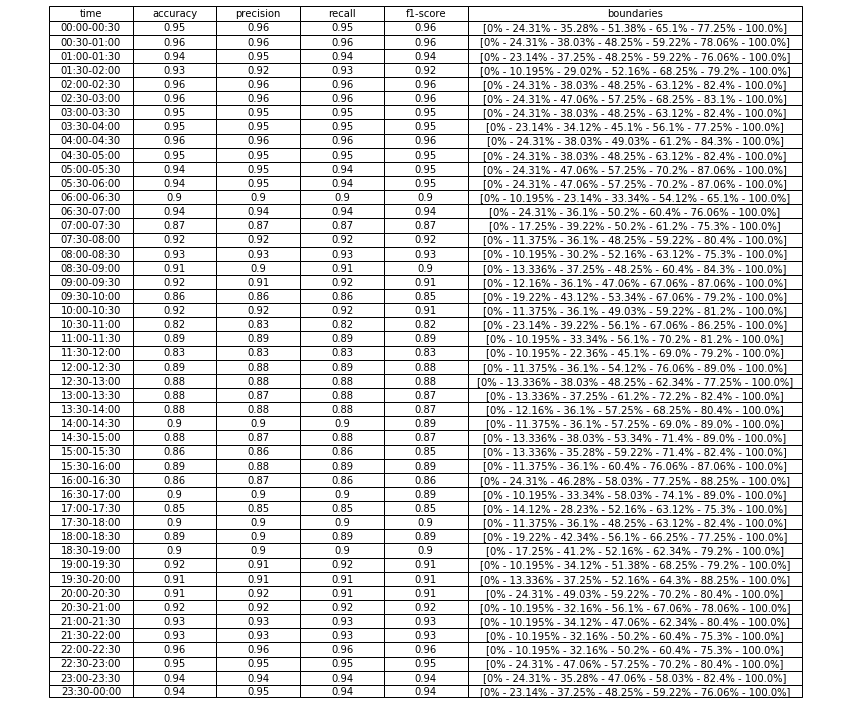

In [162]:
time = [int(i) for i in range(48)]

q = a["boundaries"].tolist()

listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)

x = np.array([])
x = np.append(x, timeIndex)
x = np.vstack((x, np.around(a["accuracy"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["precision"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["recall"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["f1Score"].tolist(), decimals=2)))
x = np.vstack((x, listOfBoundaries))
# x = x.astype(np.float16)

plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4, 0.15],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("30min-5class-lr-noPenalty-vsMerged.svg", format="svg")
plt.show(the_table)

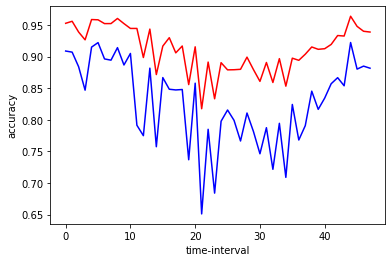

In [74]:
b = naiveDataFrameNoPenalty_30min_6class.copy()
plt.xlabel('time-interval')
plt.ylabel('accuracy')
plt.plot(time, a["accuracy"], "r")
plt.plot(time, b["accuracy"], "b")
plt.savefig("30min-6class_naive_vs_lr.svg", format="svg")
plt.savefig("30min-6class_naive_vs_lr.pdf", format="pdf")
plt.show()

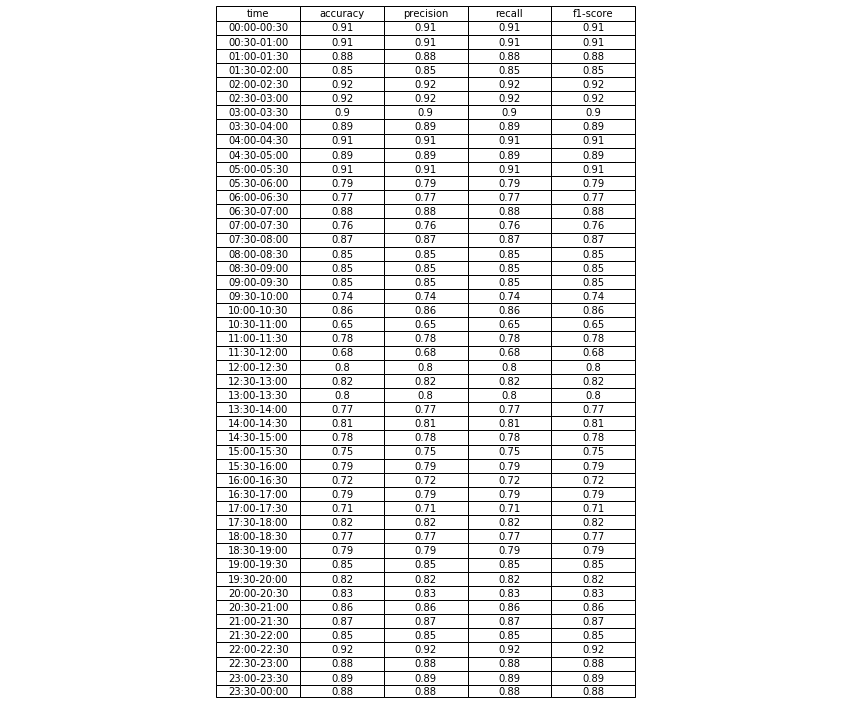

In [166]:
a = naiveDataFrameNoPenalty_30min_6class.copy()
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, timeIndex)
x = np.vstack((x, np.around(a["accuracy"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["precision"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["recall"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["f1Score"].tolist(), decimals=2)))

plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,5):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("30min-6class-naive-noPenalty-accuracy.svg", format="svg")
plt.show(the_table)

In [893]:
numberOfTestSamples = np.array([4769, 4706, 4802, 4743, 4730, 4707, 4678, 4684, 4833, 4670, 4682, 
                      4660, 4664, 4578, 4581, 4599, 4604, 4672, 4666, 4694, 4832,
                      4757, 4835, 4769, 4820, 4739, 4855, 4907, 4793, 4888, 4873,
                      4779, 4805, 4818, 4771, 4746, 4641, 4640, 4795, 4878, 4771,
                      4725, 4915, 4781, 4722, 4786, 4784, 4704])
q= a["accuracy"].tolist()
print(q)
print(np.sum(q * numberOfTestSamples))
np.sum(numberOfTestSamples)

[0.9658209268190396, 0.9594135146621334, 0.9635568513119533, 0.9278937381404174, 0.9596194503171247, 0.9579349904397706, 0.953612654980761, 0.9617847993168233, 0.9613076763914753, 0.953612654980761, 0.9455360956856045, 0.8919500645716746, 0.8919500645716746, 0.9392747924858017, 0.9257803972931674, 0.9271580778430093, 0.896611642050391, 0.9158818493150684, 0.8609087012430348, 0.8502343417128249, 0.925703642384106, 0.8419171746899307, 0.8488107549120992, 0.8563640176137555, 0.8921161825726142, 0.901244988394176, 0.8782698249227601, 0.8769105359690238, 0.8581264343834759, 0.8870703764320785, 0.8850810588959573, 0.8865871521238753, 0.8534859521331946, 0.8899958488999585, 0.8614546216726053, 0.9049726085124316, 0.9170437405731523, 0.8967672413793103, 0.9169968717413973, 0.9138991389913899, 0.9130161391741773, 0.9185185185185185, 0.9033570701932858, 0.9391340723697971, 0.9527742481999153, 0.9442122858336816, 0.9429347826086957, 0.9635568513119533]
207782.48492939788


227851

['[0% - 24.31% - 48.25% - 66.25% - 77.25% - 100.0%]', '[0% - 24.31% - 39.22% - 56.1% - 78.06% - 100.0%]', '[0% - 24.31% - 47.06% - 59.22% - 76.06% - 100.0%]', '[0% - 10.195% - 34.12% - 56.1% - 79.2% - 100.0%]', '[0% - 24.31% - 42.34% - 63.12% - 82.4% - 100.0%]', '[0% - 24.31% - 47.06% - 60.4% - 83.1% - 100.0%]', '[0% - 24.31% - 42.34% - 63.12% - 82.4% - 100.0%]', '[0% - 24.31% - 45.1% - 56.1% - 77.25% - 100.0%]', '[0% - 24.31% - 49.03% - 61.2% - 84.3% - 100.0%]', '[0% - 24.31% - 42.34% - 63.12% - 82.4% - 100.0%]', '[0% - 24.31% - 49.03% - 70.2% - 87.06% - 100.0%]', '[0% - 24.31% - 49.03% - 70.2% - 87.06% - 100.0%]', '[0% - 11.375% - 36.1% - 54.12% - 77.25% - 100.0%]', '[0% - 10.195% - 32.16% - 54.12% - 75.3% - 100.0%]', '[0% - 24.31% - 39.22% - 52.16% - 75.3% - 100.0%]', '[0% - 11.375% - 36.1% - 56.1% - 80.4% - 100.0%]', '[0% - 16.08% - 40.4% - 59.22% - 75.3% - 100.0%]', '[0% - 13.336% - 38.03% - 60.4% - 84.3% - 100.0%]', '[0% - 19.22% - 43.12% - 66.25% - 87.06% - 100.0%]', '[0% - 22.3

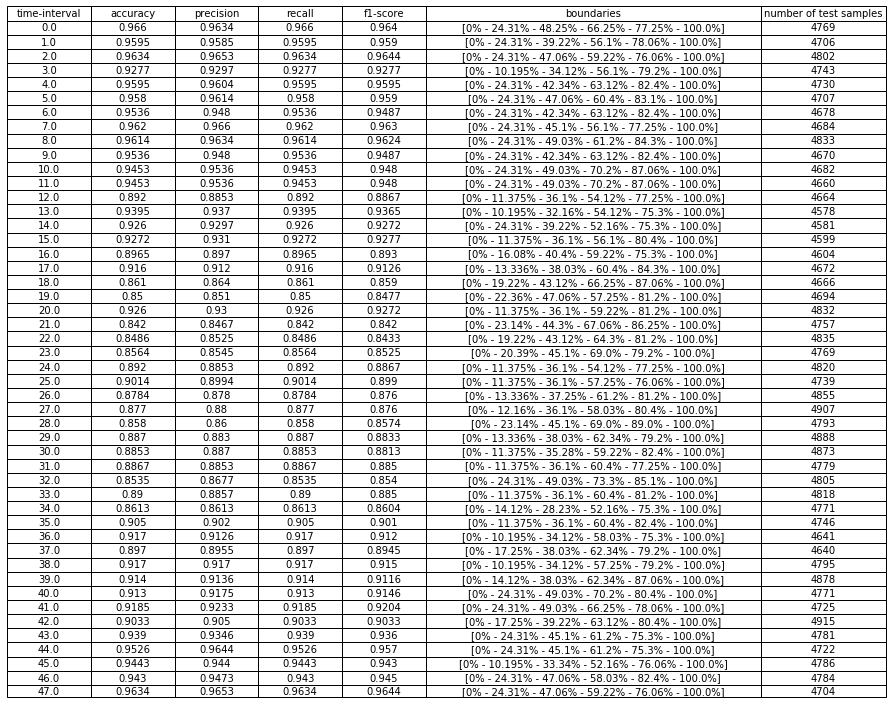

In [998]:
q = a["boundaries"].tolist()

listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
numberOfTestSamples = [4769, 4706, 4802, 4743, 4730, 4707, 4678, 4684, 4833, 4670, 4682, 
                      4660, 4664, 4578, 4581, 4599, 4604, 4672, 4666, 4694, 4832,
                      4757, 4835, 4769, 4820, 4739, 4855, 4907, 4793, 4888, 4873,
                      4779, 4805, 4818, 4771, 4746, 4641, 4640, 4795, 4878, 4771,
                      4725, 4915, 4781, 4722, 4786, 4784, 4704]
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, a["accuracy"]))
x = np.vstack((x, a["precision"]))
x = np.vstack((x, a["recall"]))
x = np.vstack((x, a["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))
x = np.vstack((x, numberOfTestSamples))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries', 
                                'number of test samples'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4, 0.15],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,7):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("30min-5class-lr-noPenalty-vsMerged.svg", format="svg")
plt.show(the_table)

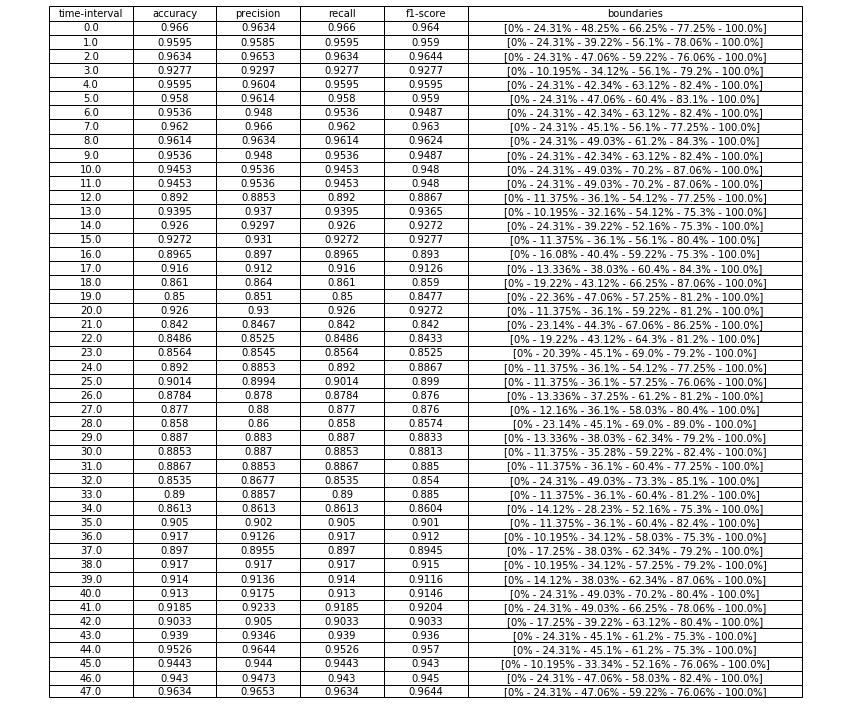

In [999]:
q = a["boundaries"].tolist()

listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, a["accuracy"]))
x = np.vstack((x, a["precision"]))
x = np.vstack((x, a["recall"]))
x = np.vstack((x, a["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))



plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("30min-5class-lr-noPenalty-25Cons.svg", format="svg")
plt.show(the_table)

In [996]:
a["boundaries"].loc[6]

array([ 24.31372549,  42.35294118,  63.1372549 ,  82.35294118,
       100.        ])

# Global Lumping

In [176]:
globlaData = data.copy()
globlaData["timeIndex"] = 0
numberOfStates = 255
global_cuTrans = processData.markovianTransitionMatrixDegree1(globlaData, numberOfStates, "CU")
global_normalizedCuTrans = processData.normalizingTransMatrix(global_cuTrans)

In [178]:
def preparingMatrixForLumping(transitionMatrix):
    reload(oldLumping)
    percentageMatrix_list = bandwidthPercentage(transitionMatrix)
    zero_cols_rows = []
    #*************removing zeros from columns and rows (matrix reduction) ****************
    for i in range(len(transitionMatrix)):
        if (np.sum(transitionMatrix[i]) == 0) and (np.sum(transitionMatrix[:,i]) == 0):
            zero_cols_rows.append(i)


    irreducible_matrix = transitionMatrix.copy()
    for i in range(len(zero_cols_rows) - 1, -1, -1):
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 0)
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 1)
        percentageMatrix_list[zero_cols_rows[i]][2] = True


    for i in range(len(percentageMatrix_list) - 1, 0, -1):
        if (percentageMatrix_list[i][2] == True) and (percentageMatrix_list[i - 1][2] == True):
            percentageMatrix_list[i - 1][0].extend(percentageMatrix_list[i][0])
            percentageMatrix_list[i - 1][1] = percentageMatrix_list[i][1]
            del percentageMatrix_list[i]

    for i in range(len(irreducible_matrix)):
        if np.sum(irreducible_matrix[i], dtype = np.float32) != 1.0:
            print(np.sum(irreducible_matrix[i], dtype = np.float32))

    return percentageMatrix_list, irreducible_matrix

def bandwidthPercentage(vectorMatrix):
    percentageIncreament = (100 / vectorMatrix.shape[0])
    percentageMatrix = []
    maxPercentage = 0
    for j in range(vectorMatrix.shape[0]):
        maxPercentage += percentageIncreament
        percentageMatrix.append([[j], maxPercentage, False])

    return percentageMatrix

In [180]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [181]:
for i in range(1):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(global_normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/global_25Cons_lumping_results_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/global_25Cons_lumping_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)
    break

0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
0.9999999
0.9999999
0.99999994
0.99999994
0.9999999
1.0000001
0.9999999
1.0000001
0.99999994
hello
we have these many sectors to check:  366134


In [383]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range(1)]
for timeIndex in range(1):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/global_25Cons_lumping_results_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

name = "/home/sepehr/thesis/APDataML/global_25Cons_lumping_boundaries.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

0


In [384]:
name = "/home/sepehr/thesis/APDataML/global_25Cons_lumping_boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [385]:
normalLumping

[[(0.5576,
   34.068359375,
   array([[6.37514660e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00],
          [1.86690834e-01, 4.22268615e-01, 3.03409882e-02, 7.62700070e-03,
           1.00208768e-03, 0.00000000e+00],
          [1.36942675e-01, 3.50318471e-01, 2.92250233e-01, 3.37690632e-02,
           2.18043064e-03, 1.95694716e-04],
          [1.41566265e-01, 1.78683386e-01, 9.93975904e-02, 2.41549296e-01,
           1.33802817e-02, 0.00000000e+00],
          [8.58585859e-02, 8.58585859e-02, 2.02020202e-02, 5.46875000e-02,
           2.75482094e-01, 3.07692308e-03],
          [1.09090909e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 3.33333333e-01]]),
   [-1, 20, 35, 48, 69, 82, 93])]]

In [387]:
percentageArray = []
for i in range(1):
    name = "/home/sepehr/thesis/APDataML/pickles/global_25Cons_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [391]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

global_25_dataFrame = pd.DataFrame(testDataFrame)
global_25_dataFrame = global_25_dataFrame.astype('object')

In [398]:
warnings.filterwarnings('ignore')
for timeIndex in range(48):
#     if len(normalLumping[timeIndex]) == 0:
#         continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[0][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[0])):
            if percentageArray[0][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[0][j][1])
                break
    boundaries = np.append(boundaries,100)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries, 1)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    global_25_dataFrame.loc[timeIndex]["accuracy"] = accuracy_result
    global_25_dataFrame.loc[timeIndex]["penalty"] = penaltyValue
    global_25_dataFrame.loc[timeIndex]["precision"] = precision
    global_25_dataFrame.loc[timeIndex]["recall"] = recall
    global_25_dataFrame.loc[timeIndex]["f1Score"] = f1Score
    global_25_dataFrame.loc[timeIndex]["boundaries"] = boundaries
    global_25_dataFrame.loc[timeIndex]["lumpAprox"] = normalLumping[0][0][0]
    global_25_dataFrame.loc[timeIndex]["lumpError"] = normalLumping[0][0][1]

0
start training set generation
19075
4769
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.941484899328859 0.9540784231495072 14.399179880651063
epoch  20 0.9522860738255033 0.9465296707905221 8.757304092781656
epoch  40 0.9529677013422819 0.9469490459215768 8.679257618900914
epoch  60 0.9518666107382551 0.9509331096665967 8.681116794579784
epoch  80 0.953125 0.9494652967079052 8.669974835327007
epoch  100 0.9528628355704698 0.9488362340113231 8.597622885400007
0.9540784231495072
1
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18820
4706
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9416454081632653 0.9445388865278368 13.618648609742015
epoch  20 0.953125 0.954313642158946 8.09037570847946
epoch  40 0.9537096088435374 0.9555886102847428 8.182873036991179
epoch  60 0.9533375850340136 0.9517637059073523 8.06435975057333
epoch  80 0.952593537414966 0.9553761155971101 8.005390305705625
epoch  100 0.9530187074829932 0.9560135996600085 7.987688581554256
epoch  120 0.9535501700680272 0.9575010624734381 8.003551571142117
epoch  140 0.9534970238095238 0.9560135996600085 7.997287633467687
epoch  160 0.9533375850340136 0.952188695282618 7.944833464565731
0.9583510412239694
2
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19204
4802
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9363020833333333 0.943981674302374 14.346090906858445
epoch  20 0.9447395833333333 0.9510620574760517 9.130086271166805
epoch  40 0.9447916666666667 0.9435651811745106 9.068937536875403
epoch  60 0.945 0.9443981674302374 8.997838087081911
epoch  80 0.9440104166666666 0.95085381091212 9.01987447977066
epoch  100 0.9453125 0.9429404414827155 9.012409520546594
0.9514785506039151
3
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18972
4743
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9344911317567568 0.9487666034155597 14.58608359581716
epoch  20 0.9461570945945946 0.9523508328062408 9.485411370324128
epoch  40 0.9463682432432432 0.9504532995994096 9.422273161443494
epoch  60 0.9459987331081081 0.9512966476913346 9.231266971375486
epoch  80 0.9460515202702703 0.9485557663925785 9.270351085711173
epoch  100 0.9466321790540541 0.9460257221168037 9.247907963556209
epoch  120 0.9464210304054054 0.9506641366223909 9.245685996236032
0.9523508328062408
4
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18919
4730
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9448093220338983 0.9505285412262157 13.283571198835217
epoch  20 0.9553495762711864 0.951585623678647 8.201024291474932
epoch  40 0.9559851694915255 0.9551797040169133 8.141988655268145
epoch  60 0.9554025423728814 0.9528541226215644 8.146390775704791
epoch  80 0.9557203389830509 0.9556025369978859 8.123604723356532
epoch  100 0.955667372881356 0.9564482029598309 8.067674547534883
epoch  120 0.9559322033898305 0.9579281183932347 8.093443884283808
0.9583509513742072
5
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



18826
4707
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9471726190476191 0.958147439983004 12.812192237701543
epoch  20 0.9571109693877551 0.9640960271935415 7.9917143573160905
epoch  40 0.9565795068027211 0.963458678563841 7.993108354660928
epoch  60 0.9563669217687075 0.963458678563841 7.931597081576886
epoch  80 0.9566857993197279 0.963458678563841 7.935550653204626
epoch  100 0.9568983843537415 0.9645209262800085 7.900633010126291
epoch  120 0.9569515306122449 0.963458678563841 7.797500191497154
epoch  140 0.9564732142857143 0.9640960271935415 7.851815488062747
epoch  160 0.9562606292517006 0.963458678563841 7.869859770041745
epoch  180 0.9564200680272109 0.9645209262800085 7.852585107696299
0.9653707244529425
6
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18712
4678
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9385166952054794 0.9519025224454896 13.853425168011277
epoch  20 0.9526969178082192 0.9531851218469432 8.198692833111705
epoch  40 0.953392551369863 0.9533988884138521 8.143480597701782
epoch  60 0.9532855308219178 0.953612654980761 8.09730665385723
epoch  80 0.9534995719178082 0.9480547242411287 8.07135901100015
epoch  100 0.952589897260274 0.9510474561778538 8.130620960095163
epoch  120 0.9529644691780822 0.9482684908080377 8.094577302875582
0.9546814878153057
7
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



KeyboardInterrupt: 

In [386]:
global_25_dataFrame

NameError: name 'global_25_dataFrame' is not defined

In [399]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "precision": precisionResult, "recall": recallResult, 
                 "f1Score": f1ScoreResult, "boundaries": boundariesResult, "lumpAprox": lumpAproxResult, 
                 "lumpError": lumpErrorResult}

global_25_dataFrame_naive = pd.DataFrame(testDataFrame)
global_25_dataFrame_naive = global_25_dataFrame_naive.astype('object')

In [400]:
warnings.filterwarnings('ignore')
for timeIndex in range(47):
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[0][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[0])):
            if percentageArray[0][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[0][j][1])
                break
    boundaries = np.append(boundaries,100)
    
    accuracy_result, precision, recall, f1Score = naive(data, timeIndex, boundaries)
    print(accuracy_result)
    
    global_25_dataFrame_naive.loc[timeIndex]["accuracy"] = accuracy_result
    global_25_dataFrame_naive.loc[timeIndex]["precision"] = precision
    global_25_dataFrame_naive.loc[timeIndex]["recall"] = recall
    global_25_dataFrame_naive.loc[timeIndex]["f1Score"] = f1Score
    global_25_dataFrame_naive.loc[timeIndex]["boundaries"] = boundaries
    global_25_dataFrame_naive.loc[timeIndex]["lumpAprox"] = normalLumping[0][0][0]
    global_25_dataFrame_naive.loc[timeIndex]["lumpError"] = normalLumping[0][0][1]


0
0.9110887434994128
1
0.9083567117231999
2
0.9036907439806715
3
0.9027197975964579
4
0.9157258235020508
5
0.9184549356223176
6
0.9171868319794784
7
0.9182749786507258
8
0.9147800173833864
9
0.9129842486164326
10
0.9003289614217969
11
0.900580770058077
12
0.8924096956128643
13
0.886087564449882
14
0.850543596908702
15
0.7755403818553472
16
0.7629909628084811
17
0.7359047904447964
18
0.7376746977621538
19
0.7083812689079211
20
0.6870342771982116
21
0.6572906155398587
22
0.6415687572397816
23
0.6354066182946777
24
0.6345643153526971
25
0.6565507344251224
26
0.650422245108136
27
0.6176266764502059
28
0.656428660852147
29
0.6637066743053567
30
0.6541208340174027
31
0.6638905164476437
32
0.6847450572320499
33
0.7101756134014199
34
0.7280539951370839
35
0.7556576341185891
36
0.7659583638636266
37
0.7726626147678779
38
0.7830802603036876
39
0.7989749897498974
40
0.8254580520732884
41
0.8307581594209034
42
0.8546897253306206
43
0.8658439656975528
44
0.8812166398373295
45
0.8736732135394902
46


In [913]:
global_25_dataFrame_naive

,accuracy,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.890497,0.890497,0.890497,0.890497,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
1,0.889782,0.889782,0.889782,0.889782,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
2,0.884362,0.884362,0.884362,0.884362,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
3,0.886148,0.886148,0.886148,0.886148,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
4,0.897797,0.897797,0.897797,0.897797,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
5,0.90116,0.90116,0.90116,0.90116,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
6,0.899786,0.899786,0.899786,0.899786,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
7,0.89842,0.89842,0.89842,0.89842,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
8,0.897852,0.897852,0.897852,0.897852,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684
9,0.89421,0.89421,0.89421,0.89421,"[23.13725490196077, 38.039215686274446, 51.37254901960773, 72.15686274509785, 85.09803921568604,...",0.557617,34.0684


In [158]:
arrTime = []
startHour = 0
startMinute = 0
for i in range(48):
    if startHour < 10:
        x = "0" + str(startHour) + ":"
    else:
        x = str(startHour) + ":"
    if startMinute == 0:
        x += "0" + str(startMinute)
        startMinute += 30
    else:
        x += str(startMinute)
        startMinute = 0
        startHour += 1
    arrTime.append(x)
# print(arrTime)

timeIndex = []
for i in range(48):
    string = str(arrTime[i-1]) + "-" + str(arrTime[i])
    timeIndex.append(string)
timeIndex.append(timeIndex[0])
del timeIndex[0]
print(timeIndex)

['00:00-00:30', '00:30-01:00', '01:00-01:30', '01:30-02:00', '02:00-02:30', '02:30-03:00', '03:00-03:30', '03:30-04:00', '04:00-04:30', '04:30-05:00', '05:00-05:30', '05:30-06:00', '06:00-06:30', '06:30-07:00', '07:00-07:30', '07:30-08:00', '08:00-08:30', '08:30-09:00', '09:00-09:30', '09:30-10:00', '10:00-10:30', '10:30-11:00', '11:00-11:30', '11:30-12:00', '12:00-12:30', '12:30-13:00', '13:00-13:30', '13:30-14:00', '14:00-14:30', '14:30-15:00', '15:00-15:30', '15:30-16:00', '16:00-16:30', '16:30-17:00', '17:00-17:30', '17:30-18:00', '18:00-18:30', '18:30-19:00', '19:00-19:30', '19:30-20:00', '20:00-20:30', '20:30-21:00', '21:00-21:30', '21:30-22:00', '22:00-22:30', '22:30-23:00', '23:00-23:30', '23:30-00:00']


In [2]:
global_25_dataFrame_naive = pd.read_pickle("global_naive_noPenalty_normal.pickle")

In [39]:
# x = a[['accuracy', 'recall']].values.tolist()
np.around(a["accuracy"].tolist(), decimals=3)
# print(x)

,accuracy,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.911089,0.911089,0.911089,0.911089,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
1,0.908357,0.908357,0.908357,0.908357,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
2,0.903691,0.903691,0.903691,0.903691,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
3,0.90272,0.90272,0.90272,0.90272,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
4,0.915726,0.915726,0.915726,0.915726,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
5,0.918455,0.918455,0.918455,0.918455,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
6,0.917187,0.917187,0.917187,0.917187,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
7,0.918275,0.918275,0.918275,0.918275,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
8,0.91478,0.91478,0.91478,0.91478,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684
9,0.912984,0.912984,0.912984,0.912984,"[24.31372549019606, 39.215686274509736, 52.156...",0.557617,34.0684


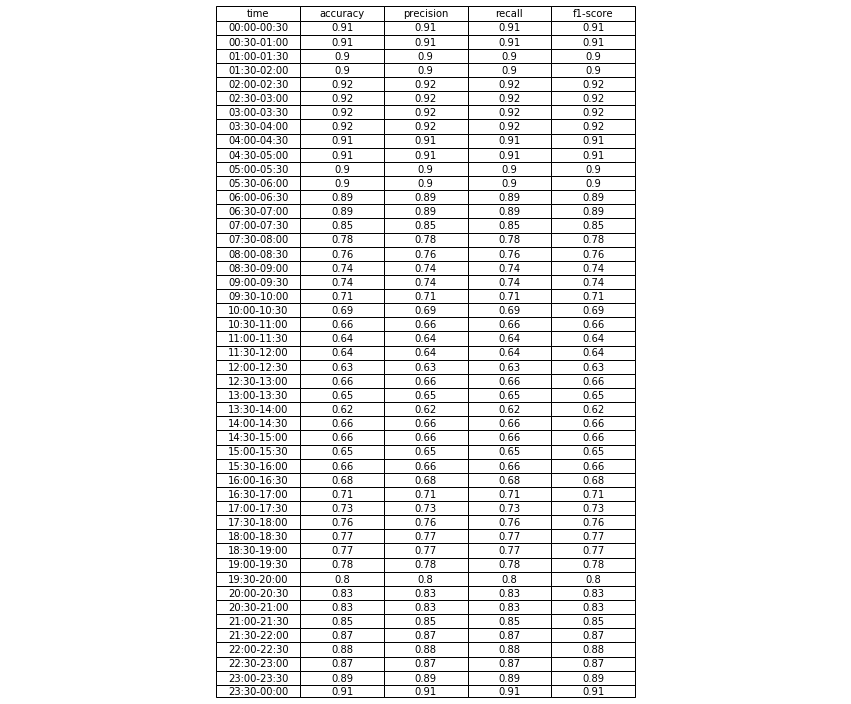

In [41]:
a = global_25_dataFrame_naive.copy()
a.loc[47] = a.loc[0]
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, timeIndex)
x = np.vstack((x, np.around(a["accuracy"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["precision"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["recall"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["f1Score"].tolist(), decimals=2)))
# x[1:,:] = x[1:,:].astype(np.float16)



plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,5):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("global_25-10_dataFrame_naive.svg", format="svg")
plt.show(the_table)

In [401]:
global_25_dataFrame_naive.to_pickle("global_naive_noPenalty_normal.pickle")

In [402]:
name = "/home/sepehr/thesis/APDataML/normalBoundaries_30min.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [403]:
percentageArray = []
for i in range(48):
    name = "/home/sepehr/thesis/APDataML/pickles/normal_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [404]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "precision": precisionResult, "recall": recallResult, 
                 "f1Score": f1ScoreResult, "boundaries": boundariesResult, "lumpAprox": lumpAproxResult, 
                 "lumpError": lumpErrorResult}

nonglobal_25_dataFrame_naive = pd.DataFrame(testDataFrame)
nonglobal_25_dataFrame_naive = nonglobal_25_dataFrame_naive.astype('object')

In [406]:
warnings.filterwarnings('ignore')
for timeIndex in range(47):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    accuracy_result, precision, recall, f1Score = naive(data, timeIndex, boundaries)
    print(accuracy_result)
    
    nonglobal_25_dataFrame_naive.loc[timeIndex]["accuracy"] = accuracy_result
    nonglobal_25_dataFrame_naive.loc[timeIndex]["precision"] = precision
    nonglobal_25_dataFrame_naive.loc[timeIndex]["recall"] = recall
    nonglobal_25_dataFrame_naive.loc[timeIndex]["f1Score"] = f1Score
    nonglobal_25_dataFrame_naive.loc[timeIndex]["boundaries"] = boundaries
    nonglobal_25_dataFrame_naive.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    nonglobal_25_dataFrame_naive.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]


0
[ 24.31372549  35.29411765  51.37254902  65.09803922  77.25490196
 100.        ]
0.9089079013588324
1
[ 24.31372549  38.03921569  48.23529412  59.21568627  78.03921569
 100.        ]
0.9071665391481765
2
[ 23.1372549   37.25490196  48.23529412  59.21568627  76.07843137
 100.        ]
0.884028992751812
3
[ 10.19607843  29.01960784  52.15686275  68.23529412  79.21568627
 100.        ]
0.846932321315623
4
[ 24.31372549  38.03921569  48.23529412  63.1372549   82.35294118
 100.        ]
0.9151338322973487
5
[ 24.31372549  47.05882353  57.25490196  68.23529412  83.1372549
 100.        ]
0.922236858879021
6
[ 23.1372549   33.33333333  46.2745098   58.03921569  69.01960784
 100.        ]
0.8964087216759299
7
[ 23.1372549   34.11764706  45.09803922  56.07843137  77.25490196
 100.        ]
0.8944491887275833
8
[ 24.31372549  38.03921569  49.01960784  61.17647059  84.31372549
 100.        ]
0.9142833491991226
10
[ 24.31372549  47.05882353  57.25490196  70.19607843  87.05882353
 100.        ]
0.

In [407]:
nonglobal_25_dataFrame_naive.to_pickle("nonglobal_naive_noPenalty_normal.pickle")

In [42]:
nonglobal_25_dataFrame_naive = pd.read_pickle("nonglobal_naive_noPenalty_normal.pickle")

In [230]:
global_25_dataFrame_naive["f1Score"].loc[47] = nonglobal_25_dataFrame_naive["f1Score"].loc[0]

In [244]:
pd.options.display.max_colwidth = 100

In [45]:
nonglobal_25_dataFrame_naive.loc[9] = nonglobal_25_dataFrame_naive.loc[8]
nonglobal_25_dataFrame_naive.loc[11] = nonglobal_25_dataFrame_naive.loc[10]
nonglobal_25_dataFrame_naive.loc[47] = nonglobal_25_dataFrame_naive.loc[0]

In [268]:
a = nonglobal_25_dataFrame_naive.copy()

In [269]:
a.drop(["lumpAprox", "boundaries", "lumpError"], axis = 1).astype(float).round(3)


,accuracy,precision,recall,f1Score
0,0.888,0.888,0.888,0.888
1,0.889,0.889,0.889,0.889
2,0.884,0.884,0.884,0.884
3,0.847,0.847,0.847,0.847
4,0.915,0.915,0.915,0.915
5,0.922,0.922,0.922,0.922
6,0.896,0.896,0.896,0.896
7,0.894,0.894,0.894,0.894
8,0.914,0.914,0.914,0.914
9,0.894,0.894,0.894,0.894


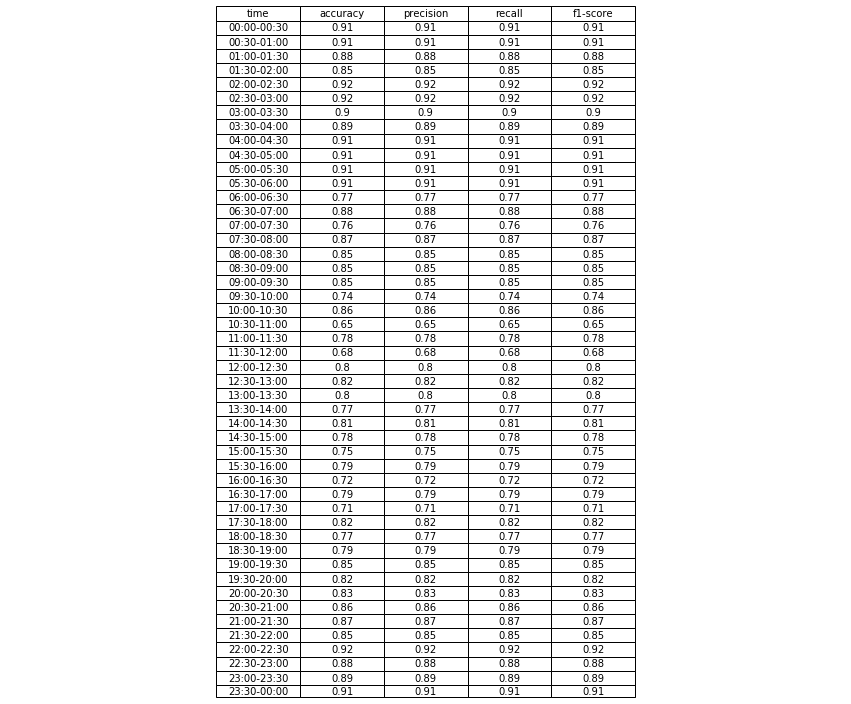

In [48]:
a = nonglobal_25_dataFrame_naive.copy()
time = [int(i) for i in range(48)]
x = np.array([])
x = np.append(x, timeIndex)
x = np.vstack((x, np.around(a["accuracy"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["precision"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["recall"].tolist(), decimals=2)))
x = np.vstack((x, np.around(a["f1Score"].tolist(), decimals=2)))



plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,5):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("nonglobal_25-10_dataFrame_naive.svg", format="svg")
plt.show(the_table)

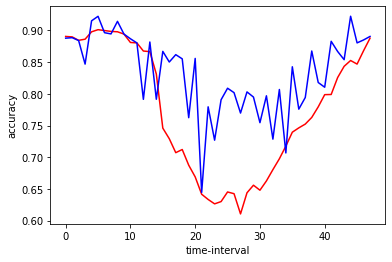

In [1006]:
a = global_25_dataFrame_naive.copy()
b = nonglobal_25_dataFrame_naive.copy()
plt.xlabel('time-interval')
plt.ylabel('accuracy')
plt.plot(time, a["accuracy"], "r")
plt.plot(time, b["accuracy"], "b")
plt.savefig("global_vs_nonGlobal.svg", format="svg")
plt.savefig("global_vs_nonGlobal.pdf", format="pdf")
plt.show()

In [270]:
import plotly.plotly as py
import plotly.figure_factory as ff
table = ff.create_table(a.drop(["lumpAprox", "boundaries", "lumpError"], axis = 1).astype(float).round(3)
, index=True)
offline.plot(table, filename='nonglobal_25_dataFrame_naive.html', image = "svg")

'nonglobal_25_dataFrame_naive.html'

# 35 constraint, 5 and 6 classes

In [931]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range(47)]
for timeIndex in range(47):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/8normal_lumping_15_result_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

name = "/home/sepehr/thesis/APDataML/4normal_correlated_35Cons_lumping_Boundaries.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [368]:
name = "/home/sepehr/thesis/APDataML/4normal_correlated_35Cons_lumping_Boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [369]:
normalLumping[1]

[(1.0,
  25.7349853515625,
  array([[0.84507042, 0.        , 0.        , 0.        , 0.        ],
         [0.5       , 0.16176471, 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.5       , 0.        ],
         [0.        , 0.        , 0.        , 1.        , 0.        ]]),
  [-1, 28, 41, 50, 66, 68])]

In [370]:
percentageArray = []
for i in range(47):
    name = "/home/sepehr/thesis/APDataML/pickles/8normal_lumping_15_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [371]:
accuracyResult = [np.inf for i in range(48)]
penaltyResult = [np.inf for i in range(48)]
precisionResult = [np.inf for i in range(48)]
recallResult = [np.inf for i in range(48)]
f1ScoreResult = [np.inf for i in range(48)]
boundariesResult = [np.inf for i in range(48)]
lumpAproxResult = [np.inf for i in range(48)]
lumpErrorResult = [np.inf for i in range(48)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

resultDataFrameNoPenalty_30min_5class_35cons = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_30min_5class_35cons = resultDataFrameNoPenalty_30min_5class_35cons.astype('object')

In [378]:
warnings.filterwarnings('ignore')
for timeIndex in range(47):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries, 1)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)

    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_30min_5class_35cons.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]


0
[  7.05882353  41.17647059  51.37254902  71.37254902 100.        ]
start training set generation
19075
4769
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9748846476510067 0.9794506185783183 6.438465933271706
epoch  20 0.979236577181208 0.9809184315370099 3.9122796244169225
epoch  40 0.9783452181208053 0.9804990564059551 3.8445991247692364
epoch  60 0.9781879194630873 0.9811281191025372 3.777011403501434
epoch  80 0.9785025167785235 0.9800796812749004 3.7417424048153345
epoch  100 0.9781354865771812 0.9807087439714824 3.743641707221133
epoch  120 0.9781879194630873 0.9802893688404277 3.7747737225770157
epoch  140 0.9783452181208053 0.9802893688404277 3.725999454348879
0.982176556930174
1
[ 34.11764706  47.05882353  56.07843137  78.03921569 100.        ]

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18820
4706
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9484481292517006 0.9932001699957501 13.392500247679598
epoch  20 0.9881483843537415 0.9923501912452188 2.8207394266564423
epoch  40 0.9884672619047619 0.9923501912452188 2.7894862558008446
epoch  60 0.9881483843537415 0.9923501912452188 2.7284805611232104
epoch  80 0.9883609693877551 0.9923501912452188 2.7173732877867374
epoch  100 0.9880420918367347 0.9923501912452188 2.729225755194012
epoch  120 0.9881483843537415 0.9923501912452188 2.6880738607981582
epoch  140 0.9882015306122449 0.9919252018699533 2.663601850672644
epoch  160 0.9881483843537415 0.9923501912452188 2.691367575049805
epoch  180 0.9879889455782312 0.9923501912452188 2.671558872714233
epoch  200 0.9884672619047619 0.9921376965575861

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[  6.2745098   38.03921569  50.19607843  72.15686275 100.        ]
start training set generation
19204
4802
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9900520833333334 0.9920866305705955 4.550869807302951
epoch  20 0.9899479166666667 0.9918783840066638 2.5110915401329588
epoch  40 0.9897916666666666 0.9908371511870054 2.46695003983875
epoch  60 0.9899479166666667 0.9916701374427322 2.489419059480229
epoch  80 0.99015625 0.9912536443148688 2.411011504158377
epoch  100 0.9901041666666667 0.9916701374427322 2.4027187162886063
0.9920866305705955
3
[ 25.09803922  52.15686275  79.21568627  84.31372549 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18972
4743
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9161211993243243 0.9550917141049968 18.982338984270363
epoch  20 0.9523859797297297 0.9593084545646215 7.482961621236157
epoch  40 0.9538112331081081 0.9580434324267342 7.474522595067282
epoch  60 0.9526499155405406 0.9582542694497154 7.3140606251922815
epoch  80 0.9538112331081081 0.9584651064726966 7.331245908463323
epoch  100 0.9533361486486487 0.954248366013072 7.341263019152589
epoch  120 0.9539168074324325 0.9584651064726966 7.331191328933107
epoch  140 0.9523331925675675 0.9576217583807717 7.338970232251528
epoch  160 0.952808277027027 0.959730128610584 7.392813828748626
epoch  180 0.9537584459459459 0.9510858106683534 7.294924926113438
epoch  200 0.9532833614864865 0.9590976175416404 7.2117

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18919
4730
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9308792372881356 0.9336152219873151 11.11723309371431
epoch  20 0.9395127118644068 0.9382663847780127 8.987067675186417
epoch  40 0.9388241525423728 0.9380549682875264 8.85021362951246
epoch  60 0.9389830508474576 0.9359408033826638 8.767711076493988
epoch  80 0.939989406779661 0.9367864693446089 8.739374753176161
epoch  100 0.938718220338983 0.9336152219873151 8.771257899979412
epoch  120 0.9398834745762712 0.9376321353065539 8.701407414775783
0.9384778012684989
5
[ 32.15686275  54.11764706  78.03921569  83.1372549  100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18826
4707
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9474914965986394 0.9883152751221584 13.598111625025872
epoch  20 0.9862351190476191 0.9887401742086255 2.850966065919318
epoch  40 0.9858630952380952 0.9883152751221584 2.816751586083247
epoch  60 0.9863945578231292 0.9878903760356915 2.7586601574455396
epoch  80 0.9862351190476191 0.988102825578925 2.806974152926684
epoch  100 0.9859162414965986 0.9878903760356915 2.7408635488324835
epoch  120 0.9864477040816326 0.9857658806033567 2.7361462251568343
epoch  140 0.9860756802721088 0.988102825578925 2.734687233609812
epoch  160 0.9861288265306123 0.988102825578925 2.702509232600327
epoch  180 0.9862351190476191 0.988102825578925 2.697740151135086
epoch  200 0.9863945578231292 0.9870405778627576 2.726

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6
[  6.2745098   41.17647059  55.29411765  90.19607843 100.        ]
start training set generation
18712
4678
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9911708047945206 0.9944420692603677 4.28150814276648
epoch  20 0.9926155821917808 0.9942283026934587 1.8959975042826918
epoch  40 0.9925085616438356 0.9944420692603677 1.8953352695241672
epoch  60 0.9925620719178082 0.9944420692603677 1.8924291991973168
epoch  80 0.9926690924657534 0.9942283026934587 1.8754884746589073
epoch  100 0.9926155821917808 0.9944420692603677 1.884967514843208
epoch  120 0.9927761130136986 0.9942283026934587 1.8444165369266108
epoch  140 0.992722602739726 0.9938007695596409 1.8290541608090678
epoch  160 0.9926155821917808 0.9940145361265498 1.8254396658620402
epoch  180 0.9925

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18736
4684
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9469713184931506 0.9925277540563621 13.778984488077365
epoch  20 0.9880672089041096 0.9918872758326217 2.571074738639265
epoch  40 0.988013698630137 0.990392826643894 2.566533930089374
epoch  60 0.9882277397260274 0.9923142613151152 2.525041579740912
epoch  80 0.9882277397260274 0.9923142613151152 2.4855334203792347
epoch  100 0.98828125 0.9923142613151152 2.5067773260023083
epoch  120 0.9881207191780822 0.9921007685738685 2.546968121464328
epoch  140 0.9881742294520548 0.9923142613151152 2.4479739496305792
epoch  160 0.9883347602739726 0.9918872758326217 2.4774436786107428
epoch  180 0.9880672089041096 0.9912467976088813 2.4541678237282256
epoch  200 0.9881742294520548 0.9923142613151152 2.4651183

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



8
[  6.2745098   41.17647059  56.07843137  84.31372549 100.        ]
start training set generation
19328
4833
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9932740066225165 0.994413407821229 3.13372603986437
epoch  20 0.9936361754966887 0.9942064969997931 1.608233154677348
epoch  40 0.9935844370860927 0.994413407821229 1.555677938577256
epoch  60 0.9937913907284768 0.994620318642665 1.5515975850813144
epoch  80 0.9937913907284768 0.994620318642665 1.548233407012971
epoch  100 0.9936361754966887 0.994413407821229 1.5652215967250878
epoch  120 0.9937913907284768 0.9942064969997931 1.5470725771113734
epoch  140 0.9938431291390728 0.994413407821229 1.5287875112405183
epoch  160 0.9937396523178808 0.994413407821229 1.5161443456501653
epoch  180 0.993739652317

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



10
[  7.05882353  41.17647059  51.37254902  70.19607843 100.        ]
start training set generation
18725
4682
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.979933647260274 0.9788551900897052 4.710499955519832
epoch  20 0.9806292808219178 0.9784280222127296 3.282011272309168
epoch  40 0.9808433219178082 0.979068774028193 3.217396205673888
epoch  60 0.9812178938356164 0.9786416061512174 3.176497006916427
epoch  80 0.980736301369863 0.9784280222127296 3.172881352472795
epoch  100 0.9818600171232876 0.981631781290047 3.119019839657497
epoch  120 0.9806292808219178 0.9784280222127296 3.156430391135486
epoch  140 0.9813249143835616 0.9794959419051688 3.1187338756065652
epoch  160 0.9813784246575342 0.9801366937206322 3.105337144245636
epoch  180 0.98089683219

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



18581
4646
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9166487068965518 0.9429616874730952 14.414159934274087
epoch  20 0.9353987068965517 0.9433921653034869 10.065165670986831
epoch  40 0.9351831896551724 0.9451140766250538 9.961725938731226
epoch  60 0.9355064655172414 0.9442531209642704 9.830388690685407
epoch  80 0.9344288793103448 0.9446835987946621 9.804293647305713
epoch  100 0.9353448275862069 0.9438226431338786 9.813495670515916
epoch  120 0.9349137931034482 0.9408092983211365 9.739106186505023
epoch  140 0.9358297413793103 0.9448988377098579 9.82220468110051
epoch  160 0.936584051724138 0.9436074042186827 9.697500614051165
epoch  180 0.9352370689655173 0.9444683598794662 9.709222611887702
0.9459750322858372
13
[  6.2745098   41.17647059  53.3

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18308
4578
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9915865384615384 0.9930100480559196 4.141370817393692
epoch  20 0.9918050699300699 0.9925731760594146 2.3284789303226483
epoch  40 0.9915319055944056 0.9927916120576671 2.2915436532478624
epoch  60 0.9915865384615384 0.9925731760594146 2.310744172001218
epoch  80 0.9914772727272727 0.9927916120576671 2.2404098139255204
epoch  100 0.9914226398601399 0.9919178680646571 2.2803904052980077
epoch  120 0.9912587412587412 0.9925731760594146 2.2712137582679315
epoch  140 0.9912587412587412 0.9927916120576671 2.2538215362212877
epoch  160 0.9914226398601399 0.9923547400611621 2.287574978558335
epoch  180 0.9916958041958042 0.9927916120576671 2.2439629959815224
epoch  200 0.9918050699300699 0.992791612057667

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18394
4599
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.7789634146341463 0.8182213524679278 31.145831370602917
epoch  20 0.8348758710801394 0.8169167210263101 22.69869866520686
epoch  40 0.8350391986062717 0.8123505109806479 22.582110095937907
epoch  60 0.8353658536585366 0.811915633833442 22.41847760004449
epoch  80 0.8343858885017421 0.8190911067623396 22.368444186885178
epoch  100 0.8367269163763066 0.8164818438791042 22.258560373392672
epoch  120 0.834984756097561 0.8217003696455751 22.264784174929098
epoch  140 0.8367813588850174 0.817134159599913 22.233768639248837
epoch  160 0.8332425958188153 0.8188736681887366 22.278797425459487
epoch  180 0.8362369337979094 0.8212654924983692 22.208049505014454
0.8258317025440313
16
[  8.23529412  43.1372549  

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18687
4672
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9533934707903781 0.9569777397260274 10.46737594088328
epoch  20 0.9636490549828178 0.9648972602739726 7.665770372574272
epoch  40 0.9650987972508591 0.9655393835616438 7.303059094345446
epoch  60 0.9654746563573883 0.9663955479452054 7.188373660303883
epoch  80 0.9657968213058419 0.9646832191780822 7.203254987488909
epoch  100 0.9645618556701031 0.9655393835616438 7.163376426369054
epoch  120 0.9654209621993127 0.9657534246575342 7.120215550423486
epoch  140 0.9655283505154639 0.9644691780821918 7.124899076432295
epoch  160 0.9654209621993127 0.9642551369863014 7.15271178553604
epoch  180 0.9660115979381443 0.9663955479452054 7.168740312463229
epoch  200 0.9651524914089347 0.9642551369863014 7.1332

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18775
4694
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.890891638225256 0.9275671069450362 23.231325966506287
epoch  20 0.9307273890784983 0.9322539412015338 12.51714806996108
epoch  40 0.9312606655290102 0.9331060928845335 12.306973428042673
epoch  60 0.9297674914675768 0.931827865360034 12.354499611838278
epoch  80 0.93035409556314 0.9335321687260333 12.277208172827446
epoch  100 0.9306740614334471 0.9277801448657861 12.270673191588083
epoch  120 0.9306207337883959 0.9328930549637836 12.354132847574387
epoch  140 0.9304074232081911 0.9328930549637836 12.30021970914899
epoch  160 0.9304607508532423 0.9337452066467832 12.329794834091395
epoch  180 0.9306207337883959 0.9333191308052834 12.283912045150084
epoch  200 0.9293941979522184 0.9282062207072859 1

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



19324
4832
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8729754983388704 0.9188741721854304 26.320066111428392
epoch  20 0.911389119601329 0.9197019867549668 14.91580008193108
epoch  40 0.911389119601329 0.9184602649006622 14.752916906363149
epoch  60 0.9132059800664452 0.9192880794701986 14.751003670137981
epoch  80 0.9125830564784053 0.9199089403973509 14.664318989281638
epoch  100 0.9122715946843853 0.9192880794701986 14.722682183763117
epoch  120 0.9120120431893688 0.9203228476821192 14.735293945204775
epoch  140 0.9127387873754153 0.9199089403973509 14.65522439772901
epoch  160 0.9123754152823921 0.9201158940397351 14.708620255175619
epoch  180 0.9125830564784053 0.9199089403973509 14.657911117686782
0.921771523178808
21
[  8.23529412  43.1372549  

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19027
4757
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9117213804713805 0.9302081143577885 18.98155681211942
epoch  20 0.9281881313131313 0.9291570317426949 14.089712345238889
epoch  40 0.9286616161616161 0.9293672482657137 14.007491955452087
epoch  60 0.9290824915824916 0.9297876813117512 14.030121313602434
epoch  80 0.9288720538720538 0.9291570317426949 13.968367470635307
epoch  100 0.9287142255892256 0.9293672482657137 14.061611594575824
0.9314694134959007
22
[ 33.33333333  68.23529412  86.2745098   92.15686275 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19337
4835
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8031353476821192 0.8599793174767322 33.53527648559468
epoch  20 0.8782595198675497 0.8763185108583247 19.34065218792846
epoch  40 0.8790355960264901 0.8777662874870734 19.21702064741526
epoch  60 0.8802773178807947 0.8765253360910031 19.073796340171878
epoch  80 0.8793977649006622 0.8800413650465356 18.99037390355242
epoch  100 0.8800186258278145 0.8759048603929679 18.959199384348288
epoch  120 0.8811568708609272 0.8810754912099276 18.900271835706086
epoch  140 0.8815707781456954 0.8798345398138573 18.880650902425998
epoch  160 0.8806394867549668 0.8794208893485005 18.89821693597251
epoch  180 0.8804842715231788 0.8802481902792141 18.942033584544195
epoch  200 0.8817259933774835 0.8779731127197518 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



23
[ 26.2745098   61.17647059  78.03921569  79.21568627 100.        ]
start training set generation
19074
4769
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.7740666946308725 0.8230236946949046 36.751025571119065
epoch  20 0.8326342281879194 0.8276368211365066 24.828547432918672
epoch  40 0.841075922818792 0.8368630740197106 23.342526179832095
epoch  60 0.8414953859060402 0.83770182428182 23.168719330090003
epoch  80 0.8413380872483222 0.8356049486265464 23.073949871447258
epoch  100 0.8413905201342282 0.8362340113231286 23.092115847056345
epoch  120 0.8421245805369127 0.8366533864541833 23.101796675048426
epoch  140 0.8413905201342282 0.83770182428182 23.115984996693253
epoch  160 0.8426489093959731 0.8379115118473475 23.022849294163244
epoch  180 0.8407

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19280
4820
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8180024916943521 0.8639004149377594 30.951178237053234
epoch  20 0.8830460963455149 0.8821576763485477 18.636038918035762
epoch  40 0.8829941860465116 0.8796680497925311 18.519771278102528
epoch  60 0.8825789036544851 0.879045643153527 18.447887273325886
epoch  80 0.8825789036544851 0.879253112033195 18.47040031439442
epoch  100 0.882734634551495 0.8811203319502074 18.39288056332408
epoch  120 0.8829422757475083 0.8831950207468879 18.434980573052204
epoch  140 0.8837728405315615 0.8796680497925311 18.457609753276028
epoch  160 0.8824231727574751 0.8815352697095435 18.43848522160933
0.8846473029045643
25
[ 11.37254902  46.2745098   81.17647059  87.05882353 100.        ]
start training set generation

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19420
4855
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8788675742574258 0.8998970133882596 23.688114820927286
epoch  20 0.8953692244224423 0.8933058702368692 17.007977857054655
epoch  40 0.897174092409241 0.9052523171987642 16.836630176002828
epoch  60 0.8988758250825083 0.8856848609680742 16.621510858189545
epoch  80 0.8989789603960396 0.8978372811534501 16.671375370655127
epoch  100 0.8983085808580858 0.9069001029866117 16.573993193434386
epoch  120 0.899082095709571 0.9031925849639547 16.634143509880545
epoch  140 0.8983085808580858 0.905870236869207 16.553817026685948
epoch  160 0.8983085808580858 0.9040164778578785 16.561595365946047
epoch  180 0.8992367986798679 0.9044284243048404 16.587797275077396
epoch  200 0.8976897689768977 0.901338825952626

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19624
4907
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.7893178104575164 0.8392092928469533 35.78514451606598
epoch  20 0.8497753267973857 0.845119217444467 23.839556379255896
epoch  40 0.850796568627451 0.8477684939881801 23.68317691329258
epoch  60 0.8526348039215687 0.8475647034848176 23.680083084729766
epoch  80 0.8508986928104575 0.8481760749949052 23.626588986590033
epoch  100 0.8514093137254902 0.8477684939881801 23.506592463823715
epoch  120 0.8526348039215687 0.8487874465049928 23.472415119993926
epoch  140 0.8522773692810458 0.8489912370083554 23.546346888822672
0.8506215610352558
28
[ 15.29411765  50.19607843  85.09803922  90.19607843 100.        ]
start training set generation
19170
4793
starting tensor
No GPU found
Tensor("Placeholder:0", s

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19549
4888
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9060963114754098 0.9138707037643208 20.651645199197237
epoch  20 0.9185450819672131 0.9185761047463176 15.655488334718298
epoch  40 0.917827868852459 0.9140752864157119 15.359336165131115
epoch  60 0.9189036885245901 0.9138707037643208 15.206305422548388
epoch  80 0.9182889344262295 0.9140752864157119 15.032016221030814
epoch  100 0.919108606557377 0.91550736497545 14.964975186645008
0.9189852700490998
30
[  8.23529412  41.17647059  76.07843137  82.35294118 100.        ]
start training set generation
19491
4873
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=flo

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



31
[ 33.33333333  49.01960784  83.1372549   95.29411765 100.        ]
start training set generation
19115
4779
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8220952181208053 0.8616865453023645 32.90571823056112
epoch  20 0.8744232382550335 0.8641975308641975 21.899052834350783
epoch  40 0.8733745805369127 0.8664992676292111 21.76179916266627
epoch  60 0.873636744966443 0.8648252772546557 21.76497556379176
epoch  80 0.8738989093959731 0.86691776522285 21.74043999422317
epoch  100 0.8739513422818792 0.8658715212387529 21.629481542830494
epoch  120 0.873794043624161 0.8650345260514752 21.539578005771517
epoch  140 0.8737416107382551 0.867964009206947 21.55217687715622
epoch  160 0.8744756711409396 0.8652437748482946 21.52337534155622
epoch  180 0.8742659395

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19220
4805
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8732291666666666 0.9078043704474505 25.252257041931138
epoch  20 0.9121354166666666 0.9086368366285119 14.633500037193299
epoch  40 0.911875 0.9071800208116545 14.444714065392809
epoch  60 0.9134895833333333 0.9096774193548387 14.375991220474246
epoch  80 0.91375 0.9075962539021852 14.442329058647156
epoch  100 0.9138541666666666 0.9103017689906348 14.34231933434804
epoch  120 0.9125 0.909261186264308 14.388826228777567
epoch  140 0.9134375 0.9086368366285119 14.356647437413534
0.9109261186264308
33
[ 27.05882353  50.19607843  84.31372549  91.37254902 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19269
4818
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.8066860465116279 0.8472395184723952 32.58513212679231
epoch  20 0.8631644518272426 0.8576172685761727 21.247944356595156
epoch  40 0.8638392857142857 0.8609381486093814 21.091802349914342
epoch  60 0.8635797342192691 0.8594852635948527 21.014133860502515
epoch  80 0.8642545681063123 0.8582399335823994 20.99195920114106
epoch  100 0.8636835548172758 0.8569946035699461 20.947822089211105
epoch  120 0.8641507475083057 0.860730593607306 20.979100445972335
0.8621834786218348
34
[  9.01960784  43.1372549   67.05882353  78.03921569 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



19083
4771
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9417470637583892 0.9526304757912387 13.30026646748485
epoch  20 0.9579488255033557 0.9566128694194089 9.067056560676368
epoch  40 0.956952600671141 0.95703206874869 9.053386833043708
epoch  60 0.9564807046979866 0.9557744707608468 8.987163710514162
epoch  80 0.9568477348993288 0.9559840704254873 8.966893386120757
epoch  100 0.9564282718120806 0.9566128694194089 8.950515912283183
0.9580800670718926
35
[  8.23529412  43.1372549   78.03921569  82.35294118 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18983
4746
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9587204391891891 0.9681837336704593 10.484510254215547
epoch  20 0.965846706081081 0.9692372524230931 7.509858302772045
epoch  40 0.965793918918919 0.966708807416772 7.359637326082666
epoch  60 0.9662690033783784 0.967551622418879 7.358604526801687
epoch  80 0.9662162162162162 0.9662873999157185 7.364349304622895
epoch  100 0.9663745777027027 0.9677623261694058 7.312216904115033
epoch  120 0.9664273648648649 0.9686051411715129 7.30542178673519
epoch  140 0.965793918918919 0.9677623261694058 7.329639963604309
epoch  160 0.9656355574324325 0.9681837336704593 7.335905867653924
epoch  180 0.965846706081081 0.9677623261694058 7.299402301778663
epoch  200 0.9653716216216216 0.9681837336704593 7.283296015

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18560
4641
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9606142241379311 0.9620771385477268 10.264737714570137
epoch  20 0.9684806034482759 0.9666020254255548 7.254924651877634
epoch  40 0.9683189655172414 0.9672484378366731 7.088038234052987
epoch  60 0.9679418103448276 0.9659556130144366 7.059372857932386
epoch  80 0.9677262931034483 0.9659556130144366 7.096983913512067
epoch  100 0.9681573275862069 0.9663865546218487 7.052036734696095
epoch  120 0.9684267241379311 0.9659556130144366 7.036911380702052
epoch  140 0.9681573275862069 0.9648782589959061 6.920322831951339
0.9672484378366731
37
[  7.05882353  38.03921569  68.23529412  79.21568627 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18559
4640
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9576665224913494 0.9683189655172414 9.067737430024724
epoch  20 0.9697772491349481 0.9698275862068966 6.794100485458506
epoch  40 0.9696691176470589 0.9698275862068966 6.691071641073917
epoch  60 0.9697231833910035 0.9691810344827586 6.726827634040871
epoch  80 0.969344723183391 0.9691810344827586 6.592183768955482
epoch  100 0.9692365916955017 0.969396551724138 6.618155654326442
epoch  120 0.9696150519031141 0.9683189655172414 6.612798357917364
0.9704741379310344
38
[  8.23529412  42.35294118  54.11764706  84.31372549 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19177
4795
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9654577759197325 0.9643378519290928 10.162488383592969
epoch  20 0.9681229096989966 0.9643378519290928 7.143427014948928
epoch  40 0.9692203177257525 0.9630865484880083 7.00099415643558
epoch  60 0.9697428929765887 0.9645464025026069 6.979003397716727
epoch  80 0.9693248327759197 0.9647549530761209 6.951471221287513
epoch  100 0.9695861204013378 0.9632950990615224 6.94184323656918
0.9657977059436913
39
[ 13.33333333  48.23529412  83.1372549   88.23529412 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19512
4878
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9083573190789473 0.9251742517425174 16.545746674663132
epoch  20 0.926038240131579 0.923329233292333 12.589526472907318
epoch  40 0.926500822368421 0.9243542435424354 12.391426222889049
epoch  60 0.9266036184210527 0.9223042230422305 12.38728814846591
epoch  80 0.926500822368421 0.923739237392374 12.404422821967222
epoch  100 0.9259868421052632 0.9243542435424354 12.37590932689215
epoch  120 0.925524259868421 0.9261992619926199 12.332270826948319
0.9282492824928249
40
[  8.23529412  43.1372549   64.31372549  69.01960784 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19080
4771
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9777160234899329 0.9784112345420247 5.949182144547471
epoch  20 0.977873322147651 0.9813456298469923 4.417997449636459
epoch  40 0.9794463087248322 0.9811360301823517 4.223333576131588
epoch  60 0.979184144295302 0.9813456298469923 4.207706980457244
epoch  80 0.9794987416107382 0.9817648291762733 4.18457280889454
epoch  100 0.9796560402684564 0.9823936281701949 4.187908511083803
epoch  120 0.9795511744966443 0.9817648291762733 4.167523597285848
epoch  140 0.9794987416107382 0.9809264305177112 4.152994107780043
epoch  160 0.9798657718120806 0.9811360301823517 4.174843878654025
epoch  180 0.9794463087248322 0.9823936281701949 4.117536202473129
epoch  200 0.9787646812080537 0.9821840285055544 4.206501

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



41
[  8.23529412  43.1372549   78.03921569  79.21568627 100.        ]
start training set generation
18898
4725
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9731991525423729 0.9739682539682539 6.991055981385507
epoch  20 0.9750529661016949 0.9756613756613757 5.023440573377126
epoch  40 0.9744703389830508 0.9754497354497355 4.88268777960438
epoch  60 0.9749470338983051 0.9733333333333334 4.880345490322278
epoch  80 0.9746822033898305 0.9746031746031746 4.893274004984712
epoch  100 0.9745762711864406 0.975026455026455 4.814381389193616
epoch  120 0.9751059322033898 0.9748148148148148 4.850738068657404
epoch  140 0.9752648305084746 0.9720634920634921 4.817549165830772
epoch  160 0.9749470338983051 0.9707936507936508 4.816338751073608
epoch  180 0.9745762711

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19124
4781
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9434773489932886 0.9807571637732692 14.704782913195219
epoch  20 0.9771392617449665 0.9813846475632713 4.654275962170333
epoch  40 0.9778208892617449 0.9813846475632713 4.6431735242473176
epoch  60 0.9768770973154363 0.9815938088266053 4.5751734404455915
epoch  80 0.9774014261744967 0.9813846475632713 4.638247551934032
epoch  100 0.9769819630872483 0.9809663250366032 4.62522050538319
epoch  120 0.9772965604026845 0.9818029700899393 4.5471015469539875
epoch  140 0.9774538590604027 0.9811754862999372 4.602346907976087
epoch  160 0.9769819630872483 0.9809663250366032 4.5718615399111036
epoch  180 0.9772441275167785 0.9813846475632713 4.576243870210329
epoch  200 0.9772441275167785 0.9811754862999372 4

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



18884
4722
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9496822033898306 0.9849639983058026 13.112034493583732
epoch  20 0.9857521186440678 0.9847522236340533 3.051479544023336
epoch  40 0.985593220338983 0.9853875476493011 2.9764532334218585
epoch  60 0.9863877118644068 0.9849639983058026 2.888657040590956
epoch  80 0.985593220338983 0.9849639983058026 2.912951979445199
epoch  100 0.986228813559322 0.9849639983058026 2.904204306082201
epoch  120 0.9863347457627119 0.9860228716645489 2.899306661193653
epoch  140 0.9863877118644068 0.983693350275307 2.864400572493924
epoch  160 0.9859110169491525 0.9858110969927997 2.908942441743308
epoch  180 0.9863347457627119 0.9855993223210504 2.8656369732345555
epoch  200 0.9860699152542373 0.9843286742905548 2.8388

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



45
[  8.23529412  43.1372549   70.19607843  72.15686275 100.        ]
start training set generation
19144
4786
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9659803511705686 0.9688675302966987 6.97724203341781
epoch  20 0.9690635451505016 0.9701211867948182 5.199864524862041
epoch  40 0.9688545150501672 0.9717927287923109 5.057497454526832
epoch  60 0.9695338628762542 0.9705390722941913 5.027979796347409
epoch  80 0.969690635451505 0.969703301295445 4.965528682322807
epoch  100 0.9695861204013378 0.970748015043878 4.97876781962787
epoch  120 0.9703177257525084 0.969703301295445 4.928288058094354
epoch  140 0.9702654682274248 0.9730463852904304 4.934306695010752
epoch  160 0.9707880434782609 0.9701211867948182 4.937817534624932
epoch  180 0.97104933110367

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19132
4784
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 60), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(61, 5) dtype=float32_ref>
Initialized
epoch  0 0.9921350671140939 0.9918478260869565 3.7669841383127527
epoch  20 0.9926069630872483 0.9903846153846154 2.1961771359279663
epoch  40 0.9925020973154363 0.9916387959866221 2.1397566909107972
epoch  60 0.9923447986577181 0.9916387959866221 2.1539019943033657
epoch  80 0.9923447986577181 0.992056856187291 2.1412968499423464
epoch  100 0.9924496644295302 0.9905936454849499 2.0957456249118653
epoch  120 0.9925020973154363 0.9914297658862876 2.110605602433919
epoch  140 0.9924496644295302 0.9914297658862876 2.084594972681678
epoch  160 0.9927642617449665 0.992056856187291 2.0751330681495226
epoch  180 0.9924496644295302 0.9910117056856187 2.0934903261270503
epoch  200 0.9927118288590604 0.9910117056856187

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [380]:
resultDataFrameNoPenalty_30min_5class_35cons

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.982177,21.9167,0.977698,0.981338,0.979508,"[7.058823529411767, 41.17647058823522, 51.3725...",1,35.9309
1,0.9932,5.56388,0.98957,0.991713,0.990581,"[34.11764705882348, 47.05882352941167, 56.0784...",1,25.735
2,0.992087,3.96478,0.985717,0.991462,0.988568,"[6.27450980392157, 38.039215686274446, 50.1960...",0.5,10.5012
3,0.959941,69.2535,0.94835,0.959519,0.949778,"[25.098039215686253, 52.156862745097925, 79.21...",0.471191,18.9576
4,0.938478,68.6397,0.931493,0.933615,0.932305,"[10.196078431372554, 45.098039215686185, 56.07...",1,27.9159
5,0.988953,19.165,0.980788,0.98789,0.983646,"[32.156862745097996, 54.11764705882341, 78.039...",0.857422,28.0491
6,0.994656,3.20334,0.990848,0.994228,0.992526,"[6.27450980392157, 41.17647058823522, 55.29411...",0.75,16.2371
7,0.992528,7.8098,0.986767,0.991887,0.988857,"[34.11764705882348, 49.01960784313715, 50.1960...",0.377197,10.5596
8,0.99462,2.52107,0.992903,0.994413,0.993226,"[6.27450980392157, 41.17647058823522, 56.07843...",1,21.3333
9,inf,inf,inf,inf,inf,inf,inf,inf


In [381]:
resultDataFrameNoPenalty_30min_5class_35cons.to_pickle("1step-30min-5class-35Cons")

In [986]:
a = resultDataFrameNoPenalty_30min_5class_35cons.copy()

In [993]:
a.loc[9] = a.loc[6]
a.loc[11] = a.loc[10]
a.loc[47] = a.loc[2]
# a["boundaries"].loc[44] = a["boundaries"].loc[43]

In [989]:
numberOfTestSamples = [4769, 4706, 4802, 4743, 4730, 4707, 4678, 4684, 4833, 4670, 4682, 
                      4660, 4664, 4578, 4581, 4599, 4604, 4672, 4666, 4694, 4832,
                      4757, 4835, 4769, 4820, 4739, 4855, 4907, 4793, 4888, 4873,
                      4779, 4805, 4818, 4771, 4746, 4641, 4640, 4795, 4878, 4771,
                      4725, 4915, 4781, 4722, 4786, 4784, 4704]
correct_prediction = np.sum((a["accuracy"] * numberOfTestSamples).astype(np.int32))
correct_prediction_precentage = correct_prediction * 100 / np.sum(numberOfTestSamples)
print(correct_prediction_precentage)

OverflowError: cannot convert float infinity to integer

[array([  7.05882353,  41.17647059,  51.37254902,  71.37254902,
       100.        ]), array([ 34.11764706,  47.05882353,  56.07843137,  78.03921569,
       100.        ]), array([  6.2745098 ,  38.03921569,  50.19607843,  72.15686275,
       100.        ]), array([ 25.09803922,  52.15686275,  79.21568627,  84.31372549,
       100.        ]), array([ 10.19607843,  45.09803922,  56.07843137,  86.2745098 ,
       100.        ]), array([ 32.15686275,  54.11764706,  78.03921569,  83.1372549 ,
       100.        ]), array([  6.2745098 ,  41.17647059,  55.29411765,  90.19607843,
       100.        ]), array([ 34.11764706,  49.01960784,  50.19607843,  77.25490196,
       100.        ]), array([  6.2745098 ,  41.17647059,  56.07843137,  84.31372549,
       100.        ]), array([  6.2745098 ,  41.17647059,  55.29411765,  90.19607843,
       100.        ]), array([  7.05882353,  41.17647059,  51.37254902,  70.19607843,
       100.        ]), array([  7.05882353,  41.17647059,  51.37254902,  70.

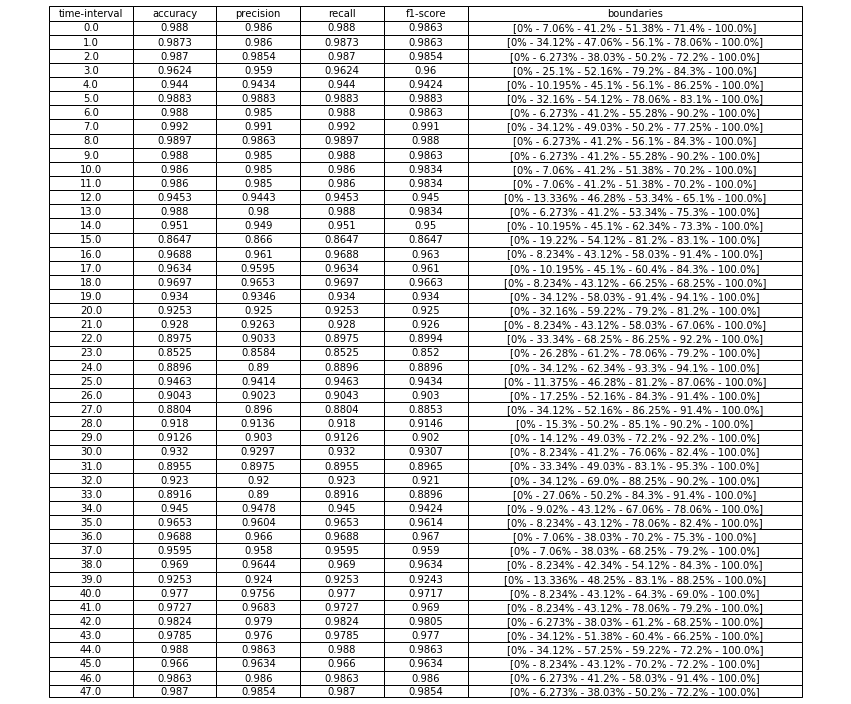

In [994]:
q = a["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
time = [int(i) for i in range(48)]

x = np.array([])
x = np.append(x, time)
x = np.vstack((x, a["accuracy"]))
x = np.vstack((x, a["precision"]))
x = np.vstack((x, a["recall"]))
x = np.vstack((x, a["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,48):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("30min-5class-lr-noPenalty-accuracy-35Cons.svg", format="svg")
plt.show(the_table)

# global dataFrame all for data

In [969]:
def globalDataPreparation(data, minuteSplit, boundaries):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    wholeDataFrame = data.copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = len(boundaries) + 1 
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    for index, row in wholeDataFrame.iterrows():
        XArraysForLearning[pandasIndexCounter, prevCU] = 1
#         for corrs in range(48):
#             XArraysForLearning[pandasIndexCounter, len(boundaries) + corrs] = row["corr" + str(corrs + 1)]

        XArraysForLearning[pandasIndexCounter, len(boundaries)] = row["normalLogDiff"]
        YArraysForLearning[pandasIndexCounter, row["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries


In [964]:
name = "/home/sepehr/thesis/APDataML/global_25Cons_lumping_boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [965]:
percentageArray = []
for i in range(1):
    name = "/home/sepehr/thesis/APDataML/pickles/global_25Cons_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [966]:
accuracyResult = [np.inf for i in range(1)]
penaltyResult = [np.inf for i in range(1)]
precisionResult = [np.inf for i in range(1)]
recallResult = [np.inf for i in range(1)]
f1ScoreResult = [np.inf for i in range(1)]
boundariesResult = [np.inf for i in range(1)]
lumpAproxResult = [np.inf for i in range(1)]
lumpErrorResult = [np.inf for i in range(1)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

global_25_dataFrame_oneIndex = pd.DataFrame(testDataFrame)
global_25_dataFrame_oneIndex = global_25_dataFrame_oneIndex.astype('object')

In [970]:
warnings.filterwarnings('ignore')
for timeIndex in range(1):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = globalDataPreparation(
        data, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    global_25_dataFrame_oneIndex.loc[timeIndex]["accuracy"] = accuracy_result
    global_25_dataFrame_oneIndex.loc[timeIndex]["penalty"] = penaltyValue
    global_25_dataFrame_oneIndex.loc[timeIndex]["precision"] = precision
    global_25_dataFrame_oneIndex.loc[timeIndex]["recall"] = recall
    global_25_dataFrame_oneIndex.loc[timeIndex]["f1Score"] = f1Score
    global_25_dataFrame_oneIndex.loc[timeIndex]["boundaries"] = boundaries
    global_25_dataFrame_oneIndex.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    global_25_dataFrame_oneIndex.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

0
[ 24.31372549  39.21568627  52.15686275  73.33333333  86.2745098
 100.        ]
start training set generation
892511
223128
starting tensor
Initialized
epoch  0 0.8612024919325924 22.6824393799673
epoch  20 0.8707309967730369 20.231049219892615
epoch  40 0.8707253944065974 20.230194265708175
epoch  60 0.8706738526353531 20.231307568110715
epoch  80 0.870689539261384 20.22922782709885
epoch  100 0.8707735747579778 20.231305738211816
epoch  120 0.8708923449264969 20.233266173472597
epoch  140 0.870784779490857 20.231329227220503
epoch  160 0.8708206346360703 20.23055354638443
epoch  180 0.8706973825743994 20.230649981117487


In [971]:
global_25_dataFrame_oneIndex

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.859251,942.528,0.862276,0.859251,0.859843,"[24.31372549019606, 39.215686274509736, 52.156862745097925, 73.33333333333314, 86.27450980392133...",0.557617,34.0684


In [975]:
numberOfTestSamples = [223128]
correct_prediction = (global_25_dataFrame_oneIndex["accuracy"] * numberOfTestSamples).astype(np.int32)
correct_prediction_precentage = correct_prediction * 100 / numberOfTestSamples
print(correct_prediction_precentage)

0    85.925119
Name: accuracy, dtype: float64


[0% - 24.31% - 39.22% - 52.16% - 73.3% - 86.25% - 100.0%]


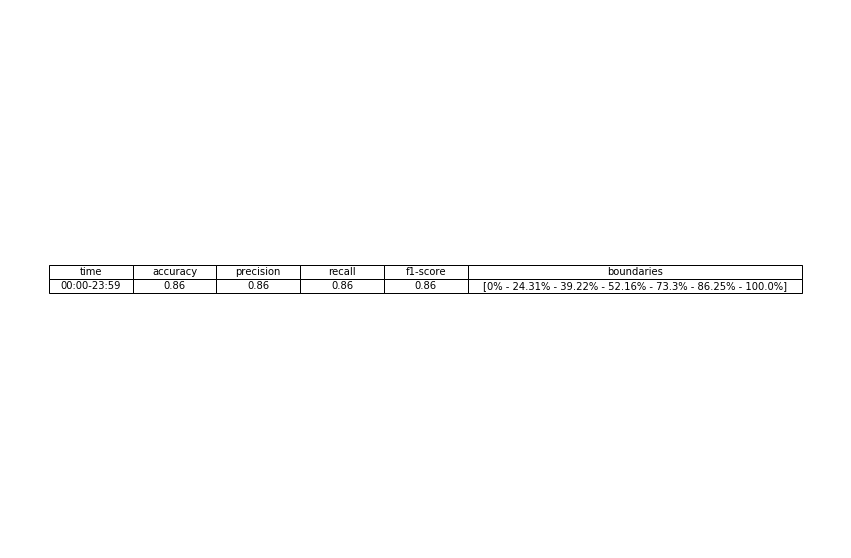

In [163]:
# a = global_25_dataFrame_oneIndex.copy()
# q = a["boundaries"].tolist()
# listOfBoundaries = []
# for i in range(len(q)):
#     string = "[0% - "
#     for j in range(len(q[i]) - 1):
#         string += str(q[i][j].astype(np.float16))
#         string += "% - "
#     string += "100.0%]"
#     listOfBoundaries.append(string)
listOfBoundaries = '[0% - 24.31% - 39.22% - 52.16% - 73.3% - 86.25% - 100.0%]'    
print(listOfBoundaries)
time = [int(i) for i in range(1)]
numberOfTestSamples = [223128]
x = np.array([])
x = np.append(x, "00:00-23:59")
x = np.vstack((x, 0.86))
x = np.vstack((x, 0.86))
x = np.vstack((x, 0.86))
x = np.vstack((x, 0.86))
# x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))
# x = np.vstack((x, numberOfTestSamples))
# x = np.vstack((x, (a["accuracy"] * numberOfTestSamples).astype(np.int32)))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,2):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("global_25_dataFrame_oneIndex.svg", format="svg")
plt.show(the_table)

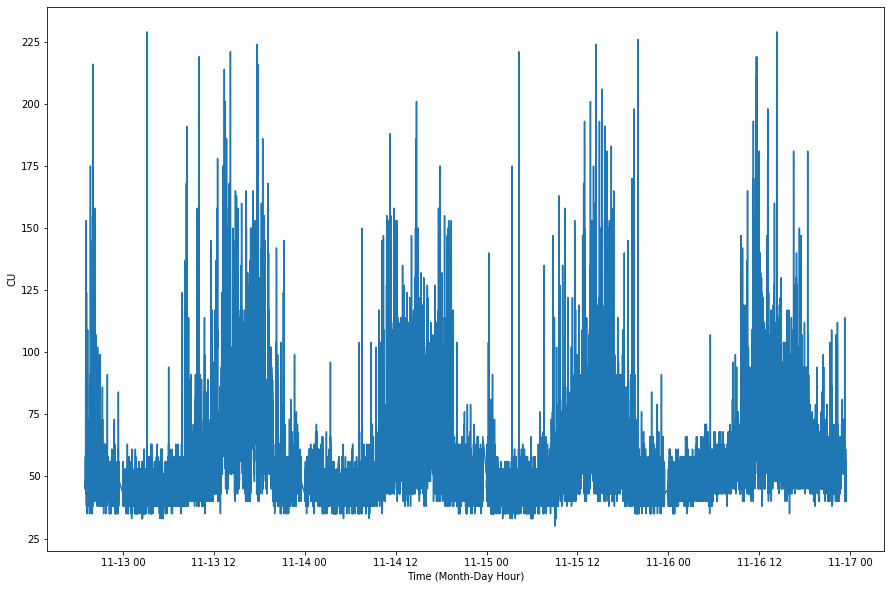

In [1052]:
a = data.loc[(data["day"] < 7)]
plt.figure(figsize=(15,10))
plt.xlabel('Time (Month-Day Hour)')
plt.ylabel('CU')
plt.plot(a["time"], a["CU"])
# plt.savefig("jumping.svg", format="svg")
plt.savefig("chanUtil.svg", format="svg")
plt.savefig("chanUtil.pdf", format="pdf")
plt.show()

In [1036]:
data["day"].unique()

array([  0.,   1.,   2.,   3.,   4.,   7.,   8.,   9.,  10.,  11.,  14.,
        15.,  16.,  17.,  18.,  21.,  22.,  23.,  24.,  25.,  28.,  29.,
        30.,  31.,  32.,  35.,  36.,  37., 141., 146., 147., 148., 149.,
       150., 153., 154., 160., 161., 162., 163., 164., 167., 168., 177.,
       178., 183., 184., 185., 188., 189., 190., 191., 192., 195., 196.,
       197., 198., 199., 201., 202., 203., 204., 205., 208., 209., 210.,
       211., 212., 215., 216., 217., 218., 219., 222., 223., 224., 225.,
       236., 237., 238., 239., 240., 243., 244., 245., 246., 247., 250.,
       251., 252., 253., 254., 257., 258., 259., 260., 264.])

In [1062]:
data = pd.read_pickle("10min_featureEngineer.pickle")
data["timeIndex"] = data["timeIndex"].astype(int)

cuTrans = processData.markovianTransitionMatrixDegree1(data, 255, "CU")

normalizedCuTrans = processData.normalizingTransMatrix(cuTrans)

cuTrans_cpy = normalizedCuTrans.copy()

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/usr/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.6/importlib/__init__.py", line 165, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 434, in su

[autoreload of _weakrefset failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/exten

]
[autoreload of collections failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/ext

In [ ]:
naiveDataFrameNoPenalty_30min_6class #30min
result_25_10_6class_10min_DataFrameNoPenalty #10min
result_25_10_6class_DataFrameNoPenalty #20min

In [379]:
print("a")

NameError: name 'result_25_10_6class_10min_DataFrameNoPenalty' is not defined